# Проект: Обучение с учителем: качество модели

- Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
- Нашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

## Декомпазировав задачу выделим основные этапы достижения нашей цели:

- Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
- Нужно собрать данные по клиентам по следующим группам:
  - Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
  - Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
  - Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
  - Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.
- Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

## Загрузка данных

In [1]:
!pip install -U scikit-learn -q

In [2]:
# устанавливаем библиотеку phik
!pip install phik -q

In [3]:
# устанавливаем библиотеку shap
!pip install shap -q

In [4]:
# устанавливаем библиотеку mlxtend
!pip install mlxtend -q

In [5]:
# импортируем необходимые библиотеки
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
shap.initjs()
from scipy.stats import shapiro
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler,
    LabelEncoder
)

from sklearn.metrics import (
    f1_score, 
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report)

from mlxtend.plotting import plot_decision_regions

Вспомогательная функция

In [6]:
class main():
    def dataframe_info(df):
        ''' Вывод информации о датафрейме `df`. Функционал схож с методом `pd.DataFrame.info()`

        Дополнительно: вывод процента заполненных (non-null) значений, количестве дублей
        '''
        info = (pd.DataFrame({
            'notNA': df.count(), 'notNA, %': df.count()/df.shape[0]*100,
            'dtype': df.dtypes})
            .style.bar(subset='notNA, %', vmin=0, color='lightblue')
            .format("{:.2f}", subset=['notNA, %'])
        )
        print('DataFrame shape  : {} rows, {} columns'.format(
            df.shape[0], df.shape[1]))
        print('Memory usage     : {:.2f} MB'.format(
            df.memory_usage().sum()/1024/1024))
        print('Duplicates count :', df.duplicated().sum())
        return info
    
        # Функция для выявлениеия неявных дубликатов типа object
    def implicit_duplicates(market):
        for col in market.columns:
            if (market[col].dtype == 'object'):
                print(col)
                print(market[col].unique())
                
        # функция приведения названия колонок к змеиному формату, и нижнему регистру.
    def separation(cols) -> list:
        new_cols = []
        for i in cols:
            tmp = i.split(" ")
            for index, word in enumerate(tmp):
                tmp[index] = word.lower()
            new_cols.append("_".join(tmp))
        return new_cols
    
    def show_hists(data, data_label, num_bins, rug=False, log_scale=False):
        """
        input: data - данные для построения гистограммы
               data_label - описание данных
               num_bins - количество ячеек
        output: None
        description: Функция строит гистограмму и boxplot для выбранного параметра:
                    - Плотность распределения (методом histplot() библиотеки seaborn)
                    - Boxplot (метод boxplot() библиотеки seaborn)
        """
        sns.set()
        f, axes = plt.subplots(1, 2, figsize=(16, 4))
        axes[0].set_title(data_label + ". Плотность распределения", fontsize=18)
        axes[0].set_ylabel('плотность', fontsize=15)
        sns.histplot(data, bins=num_bins, kde=True, ax=axes[0])
        axes[1].set_title(data_label + ". Boxplot", fontsize=18)
        sns.boxplot(data=market_file, x=data_label, ax=axes[1])
        plt.show()
        
        
        # собственная функция для преобразования категориального признака с двумя значениями в числовой бинарный признак
    def to_binary_func(value):
        '''
        Принимает отдельный столбец из фрейма данных, содержащий категориальные значения.
        Предварительно необходимо задать переменные: 
        cat_value_one (будет преобразовано в 1), 
        cat_value_two (будет преобразовано в 0), 
        и сохранить в них категориальные значения исходного pandas.Series.
        
        Args:
            value (pandas.core.series.Series) - переменная с категориальными значениями
    
        Returns:
            Столбец с преобразованными значениями (0, 1)
        '''  
        try:
            if value == cat_value_one:
                return 1
            elif value == cat_value_two:
                return 0
        except:
            return 'Error'
        
        # собственная функция для преобразования числового бинарного признака в бинарный категориальный
    def revers_binary_func(value):
        '''
        Принимает отдельный столбец из фрейма данных, содержащий числовой бинарный признак.
        Предварительно необходимо задать категориальные переменные: 
        cat_value_one (на что будет преобразована 1), 
        cat_value_two (на что будет преобразован 0).
        
        Args:
            value (pandas.core.series.Series) - переменная с числовыми значениями
    
        Returns:
            Столбец с преобразованными значениями (cat_value_one, cat_value_two)
        '''  
        try:
            if value == 1:
                return cat_value_one
            elif value == 0:
                return cat_value_two
        except:
            return 'Error'

In [7]:
# создадиим линии для разделения разделов и датафреймов
line_1 = '*'*127
line_2 = '*'*127

In [8]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [9]:
# настраиваем отображение таблиц
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [10]:
try:
    market_file = pd.read_csv('market_file.csv')
except:
    market_file = pd.read_csv('/datasets/market_file.csv')
try:
    market_money = pd.read_csv('market_money.csv')
except:
    market_money = pd.read_csv('/datasets/market_money.csv')
try:
    market_time = pd.read_csv('market_time.csv')
except:
    market_time = pd.read_csv('/datasets/market_time.csv')
try:
    money = pd.read_csv('money.csv')
except:
    money = pd.read_csv('/datasets/money.csv', sep = ';', decimal = ',')   

In [11]:
display(market_file.head(5))

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

In [12]:
display(market_money.head(5))

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [13]:
display(market_time.head(5))

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

In [14]:
display(money.head(5))

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

#### Вывод по загрузке данных

Данные соответсвуют описаниям заказчика

## Предобработка данных

In [15]:
main.dataframe_info(market_file)

DataFrame shape  : 1300 rows, 13 columns
Memory usage     : 0.13 MB
Duplicates count : 0


In [16]:
main.dataframe_info(market_money)

DataFrame shape  : 3900 rows, 3 columns
Memory usage     : 0.09 MB
Duplicates count : 0


In [17]:
main.dataframe_info(market_time)

DataFrame shape  : 2600 rows, 3 columns
Memory usage     : 0.06 MB
Duplicates count : 0


In [18]:
main.dataframe_info(money)

DataFrame shape  : 1300 rows, 2 columns
Memory usage     : 0.02 MB
Duplicates count : 0


In [19]:
main.implicit_duplicates(market_file)

Покупательская активность
['Снизилась' 'Прежний уровень']
Тип сервиса
['премиум' 'стандартт' 'стандарт']
Разрешить сообщать
['да' 'нет']
Популярная_категория
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [20]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace('стандартт', 'стандарт')

In [21]:
main.implicit_duplicates(market_money)

Период
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


In [22]:
market_money['Период'] = market_money['Период'].replace('препредыдущий_месяц', 'предпредыдущий_месяц')

In [23]:
main.implicit_duplicates(market_time)

Период
['текущий_месяц' 'предыдцщий_месяц']


In [24]:
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

Обнаружены неявные дубликаты в словах стандартт, препредыдущий_месяц, предыдцщий_месяц, заменим их.

In [25]:
# Приведем название колонок к змеиному формату и нижнему регистру, воспльзуемся функцией separation.
market_file.columns = main.separation(market_file.columns)
market_time.columns = main.separation(market_time.columns)
market_money.columns = main.separation(market_money.columns)
money.columns = main.separation(money.columns)

In [26]:
display(market_file.head())
display(market_time.head())
display(market_money.head())
display(money.head())

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась    стандарт                нет   
3  215351                 Снизилась    стандарт                 да   
4  215352                 Снизилась    стандарт                нет   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

id            период  минут
0  215348     текущий_месяц     14
1  215348  предыдущий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдущий_месяц     12
4  215350     текущий_месяц     13

id                период  выручка
0  215348  предпредыдущий_месяц      0.0
1  215348         текущий_месяц   3293.1
2  215348      предыдущий_месяц      0.0
3  215349  предпредыдущий_месяц   4472.0
4  215349         текущий_месяц   4971.6

id  прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

#### Вывод.
- во всех датафреймах отсутствую пропущенные значения,
- дублика отсутствуют, но есть неявные дубликаты - избавились от них,
- названия колонок были частично в змеином формате - обработали все названия колонок, привели к змеиному формату и нижнему регистру.
- в данных по выручке есть нулевые значения, нужно будет проверить эти данные.


## Исследовательский анализ данных

#### Анализ категориальных признаков

In [27]:
categorial_column = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']

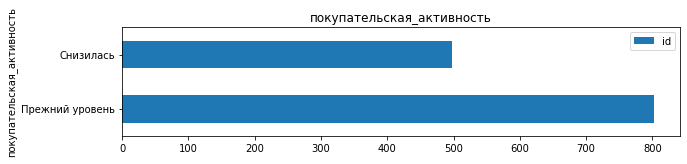

Соотношение максимальной группы к минимальной:           1.61
                            id
покупательская_активность     
Прежний уровень            802
Снизилась                  498


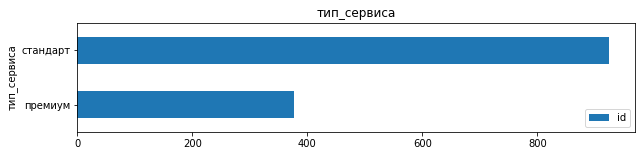

Соотношение максимальной группы к минимальной:           2.46
              id
тип_сервиса     
премиум      376
стандарт     924


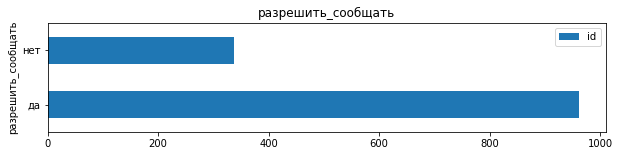

Соотношение максимальной группы к минимальной:           2.85
                     id
разрешить_сообщать     
да                  962
нет                 338


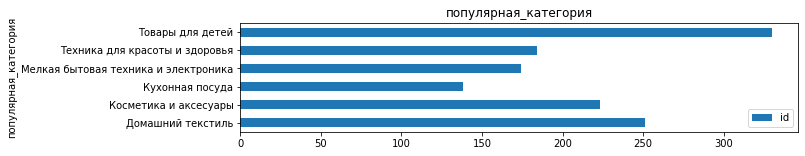

Соотношение максимальной группы к минимальной:           2.39
                                       id
популярная_категория                     
Домашний текстиль                     251
Косметика и аксесуары                 223
Кухонная посуда                       138
Мелкая бытовая техника и электроника  174
Техника для красоты и здоровья        184
Товары для детей                      330


In [28]:
for col in categorial_column:
    data_categorial = market_file.pivot_table(index = col, values = 'id', aggfunc = 'count')
    data_categorial.plot.barh(figsize=(10, 2))
    plt.title(col)
    plt.show()
    print(f"Соотношение максимальной группы к минимальной: \
          {(data_categorial['id'].max() / data_categorial['id'].min()).round(2)}")
    print(data_categorial)

Анализируя категориальные признаки можно сказать следующее:
- прежний уровень покупательской активности поддерживает большинство, 802 пользователя,
- пользователей с стандартной подпиской больше в 2.46 раза, чем с премиум подпиской,
- в основном покупатели дают согласие на то, что бы им сообщали о дополнительные предложения о товаре этот выбор делают 962 пользователя из 1300.
- самая популярная категория - товары для детей ее выбирают 330 пользователей из 1300, а из всего списка самая менее популярная - кухонная посуда, ей предпочения отдают 138 пользователй.

#### Анализ количественных признаков

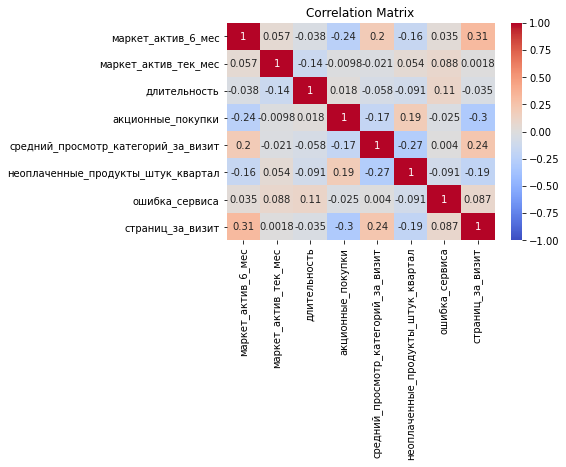

In [29]:
numeric_features = ['маркет_актив_6_мес','маркет_актив_тек_мес','длительность', 'акционные_покупки', 
                   'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 
                   'ошибка_сервиса', 'страниц_за_визит']
sns.heatmap(market_file[numeric_features].corr(),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Рассмотрев корреляционную матрицу числовых значений можно сказать что, зависимости между ними очень слабая.

In [30]:
market_file.describe()

id  маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
count    1300.000000         1300.000000           1300.000000   1300.000000   
mean   215997.500000            4.253769              4.011538    601.898462   
std       375.421985            1.014814              0.696868    249.856289   
min    215348.000000            0.900000              3.000000    110.000000   
25%    215672.750000            3.700000              4.000000    405.500000   
50%    215997.500000            4.200000              4.000000    606.000000   
75%    216322.250000            4.900000              4.000000    806.000000   
max    216647.000000            6.600000              5.000000   1079.000000   

       акционные_покупки  средний_просмотр_категорий_за_визит  \
count        1300.000000                           1300.00000   
mean            0.319808                              3.27000   
std             0.249843                              1.35535   
min             0.000000                              1.00000   
25%             0.170000                              2.00000   
50%             0.240000                              3.00000   
75%             0.300000                              4.00000   
max             0.990000                              6.00000   

       неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
count                         1300.000000     1300.000000       1300.000000  
mean                             2.840000        4.185385          8.176923  
std                              1.971451        1.955298          3.978126  
min                              0.000000        0.000000          1.000000  
25%                              1.000000        3.000000          5.000000  
50%                              3.000000        4.000000          8.000000  
75%                              4.000000        6.000000         11.000000  
max                             10.000000        9.000000         20.000000

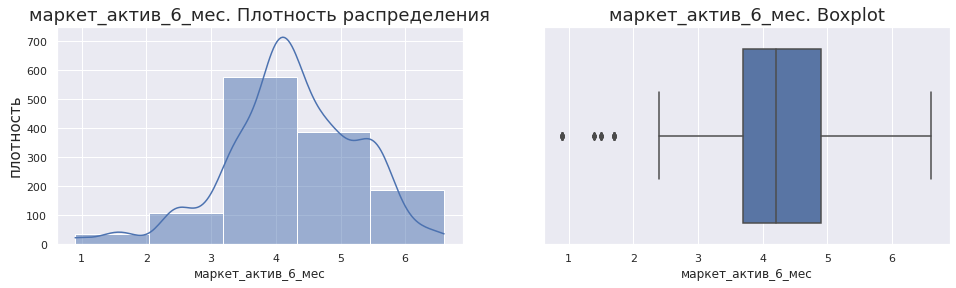

stat=0.978, p=0.000

Probably not Gaussian


count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64

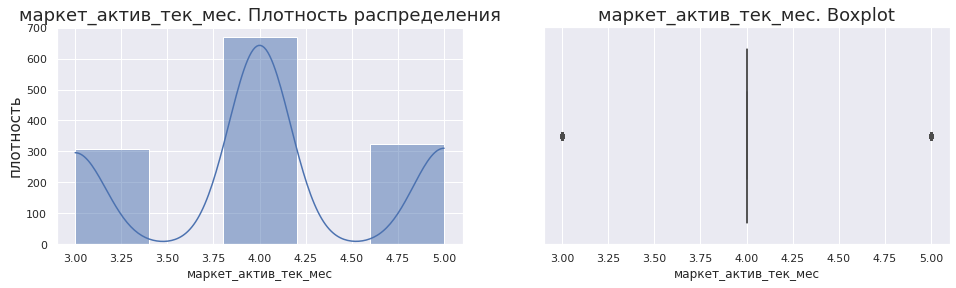

stat=0.806, p=0.000

Probably not Gaussian


count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64

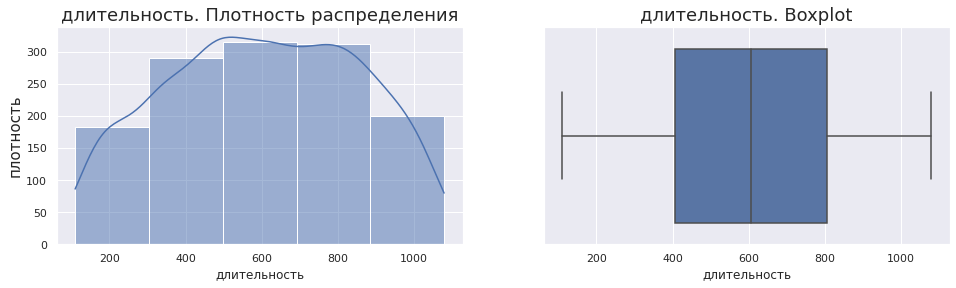

stat=0.973, p=0.000

Probably not Gaussian


count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64

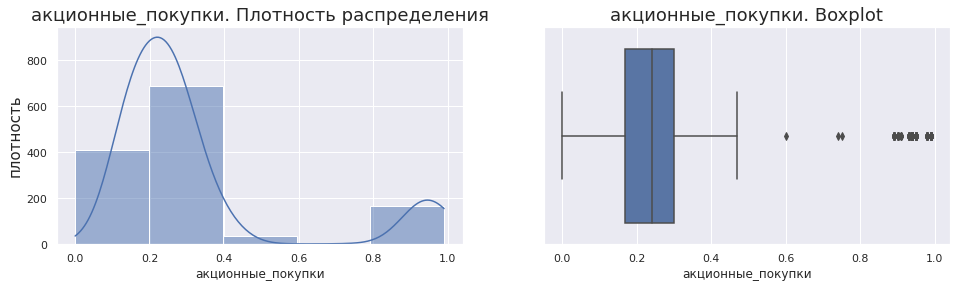

stat=0.662, p=0.000

Probably not Gaussian


count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64

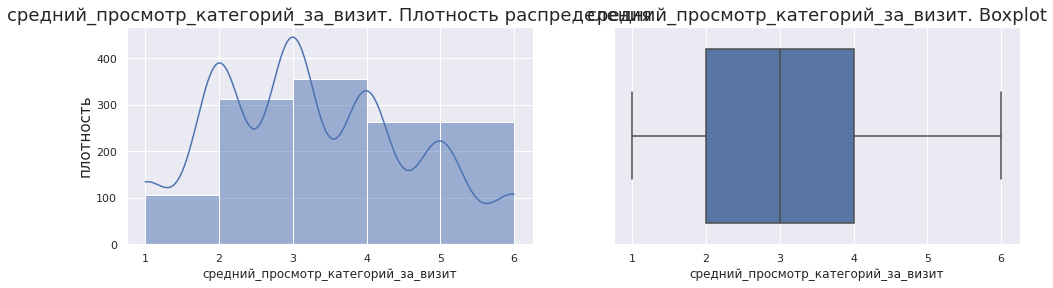

stat=0.931, p=0.000

Probably not Gaussian


count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: средний_просмотр_категорий_за_визит, dtype: float64

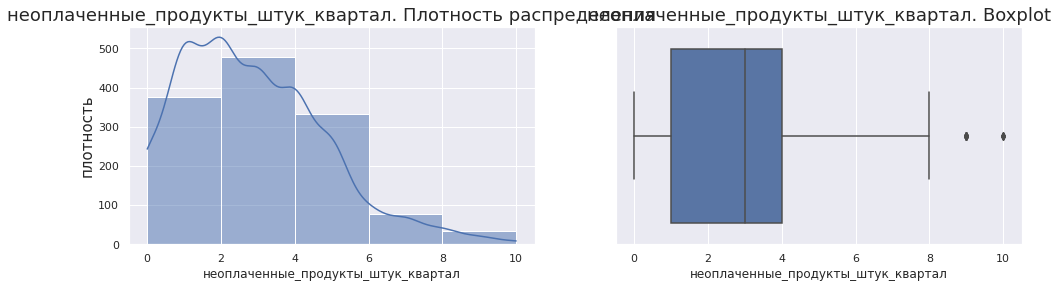

stat=0.933, p=0.000

Probably not Gaussian


count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64

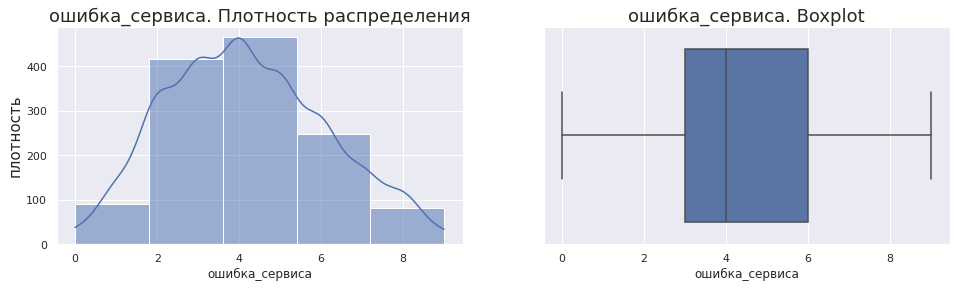

stat=0.966, p=0.000

Probably not Gaussian


count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64

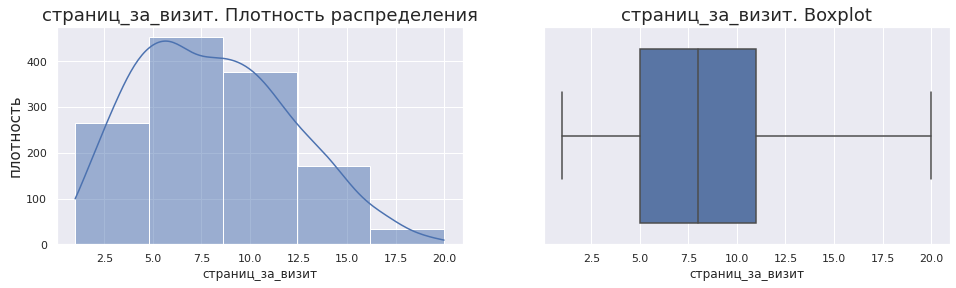

stat=0.974, p=0.000

Probably not Gaussian


count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64

In [31]:
for column in numeric_features:
    main.show_hists(market_file[column], 
               column, num_bins=math.ceil(np.log(len(market_file['маркет_актив_6_мес'].unique())) + 1))
    stat, p = shapiro(market_file[column])
    # Проверяем нормальность распределения.
    # 1. Если p-значение ≤ 0,05, то мы отклоняем нулевую гипотезу, то есть предполагаем, 
    # что распределение нашей переменной не является нормальным / гауссовым.
    # 2. Если p-значение > 0,05, то мы не можем отклонить нулевую гипотезу, т.е. мы предполагаем, 
    # что распределение нашей переменной является нормальным / гауссовским.
    print('stat=%.3f, p=%.3f\n' % (stat, p))
    if p > 0.05:
        print('Probably Gaussian')
    else:
        print('Probably not Gaussian')
    display(market_file[column].describe())

- ни один из количественных признаков не является нормальным / гауссовым,
- количество маркетинговых коммуникаций в текущем месяце распределенно очень сжато первый, второй и третий квартили совпадают,
- длительность распределена более менее равномерно среди всех пользователей, но, безусловно, имеются и отдельные случаи(например самые давние пользователи). Медиана -606, макс - 1079, мин - 110,
- распределение доли среднемесячных акционных покупок за 6 месяцев имеет два локальных максимума, в районе 0.3 и ближе к 1.0, Медиана - 0.24, макс - 0.99, мин - 0,
- распределение среднего количества просмотров категорий за визит показывает что в среднем люди смотрят на 3 категории за визит, и максимум 6, вряд ли человек целенаправленно решил рассматривать именно 6 категорий перед посещением сайта, могу предположить что на таких клиентов хорошо работают рекомендации, чего нельзя сказать о пользователях с 1 просмотренной категорией - эти люди пришли за чем то конкретным, остальное их в данный момент не интерисовало.
- общее число неоплаченных товаров в корзине за последние 3 месяца показывает что в основном у пользователей 3 неоплаченых товара, и максимум - 10,
- число сбоев, которые коснулись покупателя во время посещения сайта, было бы не плохо вести статистику ошибок, данные в таком формате малоинформативны, мы просто видим наличие ошибки, а что именно привело к ней? определенная процедура клиента? или же сбои сайта и ошибки были в одно время у всех пользователей, нужно будет попросить заказчика ввести описание ошибок (или передать нам эти описания если они есть), для выявления и устранения коренной причины появления ошибок. ну а по тем данным что есть можно сказать что в среднем у пользователей 4 ошибки, максимум 9,
- среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца. в среднем пользователи смотрят по 8 страниц, а максимум 20.


Посмотрим на выбросы в данных

In [32]:
market_file.query('неоплаченные_продукты_штук_квартал >= 8')

id покупательская_активность тип_сервиса разрешить_сообщать  \
55    215403                 Снизилась     премиум                 да   
66    215414                 Снизилась     премиум                 да   
72    215420                 Снизилась    стандарт                 да   
73    215421                 Снизилась     премиум                нет   
85    215433                 Снизилась    стандарт                 да   
88    215436                 Снизилась    стандарт                 да   
111   215459                 Снизилась     премиум                 да   
117   215465                 Снизилась    стандарт                 да   
118   215466                 Снизилась     премиум                нет   
130   215478                 Снизилась    стандарт                 да   
133   215481                 Снизилась    стандарт                 да   
151   215499                 Снизилась    стандарт                 да   
176   215524                 Снизилась    стандарт                 да   
178   215526                 Снизилась    стандарт                 да   
186   215534                 Снизилась     премиум                нет   
199   215547                 Снизилась     премиум                нет   
202   215550                 Снизилась     премиум                 да   
204   215552                 Снизилась    стандарт                 да   
216   215564                 Снизилась    стандарт                нет   
238   215586                 Снизилась     премиум                 да   
242   215590                 Снизилась    стандарт                нет   
245   215593                 Снизилась     премиум                нет   
246   215594                 Снизилась    стандарт                 да   
251   215599                 Снизилась    стандарт                 да   
263   215611                 Снизилась    стандарт                 да   
307   215655                 Снизилась    стандарт                 да   
320   215668                 Снизилась     премиум                 да   
348   215696                 Снизилась     премиум                 да   
350   215698                 Снизилась    стандарт                 да   
360   215708                 Снизилась     премиум                 да   
385   215733                 Снизилась    стандарт                нет   
581   215929                 Снизилась     премиум                 да   
592   215940                 Снизилась     премиум                 да   
1213  216561           Прежний уровень    стандарт                 да   

      маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
55                   1.7                     5           771   
66                   4.0                     4           768   
72                   3.5                     5           449   
73                   4.0                     5           523   
85                   4.0                     4           753   
88                   4.6                     3           844   
111                  4.1                     4           768   
117                  3.5                     5           449   
118                  2.4                     5           523   
130                  4.1                     4           753   
133                  3.8                     3           844   
151                  3.4                     4           842   
176                  3.0                     3           474   
178                  3.1                     4           572   
186                  4.0                     4           419   
199                  2.6                     3           308   
202                  3.0                     4           434   
204                  0.9                     4           624   
216                  3.9                     3           618   
238                  4.1                     4           557   
242                  2.4                     4           427   
245                  4.6                     3

In [33]:
market_file.query('неоплаченные_продукты_штук_квартал >= 8').value_counts().sum()

34

Из наблюдений видно что, у людей с 8ми и более неоплаченными товарами в корзине в 33 из 34 случаев покупательская активность снизилась.

In [34]:
market_file.query('акционные_покупки >= 0.6')

id покупательская_активность тип_сервиса разрешить_сообщать  \
1     215349                 Снизилась     премиум                 да   
3     215351                 Снизилась    стандарт                 да   
4     215352                 Снизилась    стандарт                нет   
14    215362                 Снизилась     премиум                 да   
16    215364                 Снизилась     премиум                 да   
...      ...                       ...         ...                ...   
1254  216602           Прежний уровень    стандарт                нет   
1256  216604           Прежний уровень    стандарт                 да   
1257  216605           Прежний уровень    стандарт                 да   
1292  216640           Прежний уровень    стандарт                нет   
1299  216647           Прежний уровень     премиум                 да   

      маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
1                    4.4                     4           819   
3                    3.2                     5           896   
4                    5.1                     3          1064   
14                   4.2                     4           438   
16                   4.3                     4           708   
...                  ...                   ...           ...   
1254                 3.4                     5           170   
1256                 4.9                     5           350   
1257                 3.2                     4           568   
1292                 5.7                     4           416   
1299                 4.0                     5           906   

      акционные_покупки                  популярная_категория  \
1                  0.75                      Товары для детей   
3                  0.99                      Товары для детей   
4                  0.94                      Товары для детей   
14                 0.74                     Домашний текстиль   
16                 0.98                     Домашний текстиль   
...                 ...                                   ...   
1254               0.95        Техника для красоты и здоровья   
1256               0.99                     Домашний текстиль   
1257               0.94  Мелкая бытовая техника и электроника   
1292               0.95                       Кухонная посуда   
1299               0.94        Техника для красоты и здоровья   

      средний_просмотр_категорий_за_визит  неоплаченные_продукты_штук_квартал  \
1                                       4                                   4   
3                                       5                                   0   
4                                       3                                   2   
14                                      3                                   4   
16                                      3                                   3   
...                                   ...                                 ...   
1254                                    4                                   1   
1256                                    3                                   4   
1257                                    5                                   1   
1292                                    2                                   3   
1299                                    4                                   5   

      ошибка_сервиса  страниц_за_визит  
1                  2                 5  
3                  6                 4  
4                  3                 2  
14                 6                 4  
16                 3                 3  
...              ...               ...  
1254               3                10  
1256               5                 5  
1257               7                11  
1292               5                13  
1299               3                12  

[168 rows x 13 columns]

In [35]:
market_file.query('акционные_покупки >= 0.6').value_counts().sum()

168

Данные пользователи в основном совершают покупки по акции, у некоторых пользователей такая доля достигает 99% от всех покупок, ничего необычного, просто люди очень любят скидки.

In [36]:
def show_hists_market_time(data, data_label, num_bins, rug=False, log_scale=False):
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(data_label + ". Плотность распределения", fontsize=18)
    axes[0].set_ylabel('плотность', fontsize=15)
    sns.histplot(data, bins=num_bins, kde=True, ax=axes[0])
    axes[1].set_title(data_label + ". Boxplot", fontsize=18)
    sns.boxplot(data=market_time, x=data_label, ax=axes[1])
    plt.show()

In [37]:
coll = 'минут'

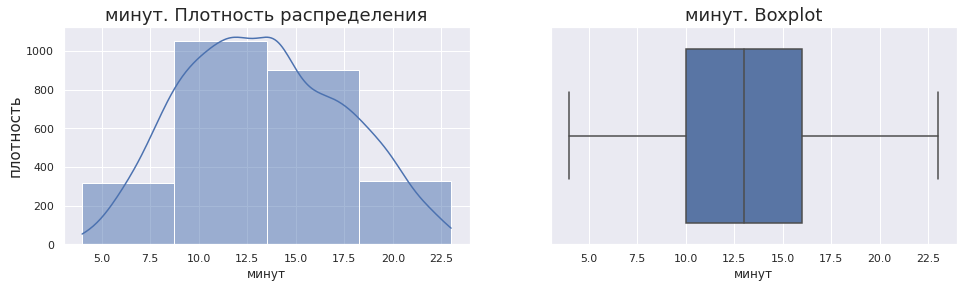

stat=0.983, p=0.000

Probably not Gaussian


count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

In [38]:
show_hists_market_time(market_time[coll], coll, num_bins=math.ceil(np.log(len(market_time['минут'].unique())) + 1))
stat, p = shapiro(market_time[coll])
print('stat=%.3f, p=%.3f\n' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')
display(market_time[coll].describe())

По графику видно, что среднее значение времени провождения на сайте = 13 минутам, мин значением = 4 минутам и макс значением = 23 минуты.

In [39]:
data_minute_on_site = pd.pivot_table(market_time, values=['минут'], index=['период'],
                       aggfunc=("min", "max", "mean"))
data_minute_on_site

минут                
                   max       mean  min
период                                
предыдущий_месяц  23.0  13.467692  5.0
текущий_месяц     23.0  13.204615  4.0

Проанализировав предыдущий и текущий месяц видим что в средних, минимальных и максимальных значениях разницы практически нет.

In [40]:
def show_hists_money(data, data_label, num_bins, rug=False, log_scale=False):
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(data_label + ". Плотность распределения", fontsize=18)
    axes[0].set_ylabel('плотность', fontsize=15)
    sns.histplot(data, bins=num_bins, kde=True, ax=axes[0])
    axes[1].set_title(data_label + ". Boxplot", fontsize=18)
    sns.boxplot(data=money, x=data_label, ax=axes[1])
    plt.show()

In [41]:
money_profit = 'прибыль'

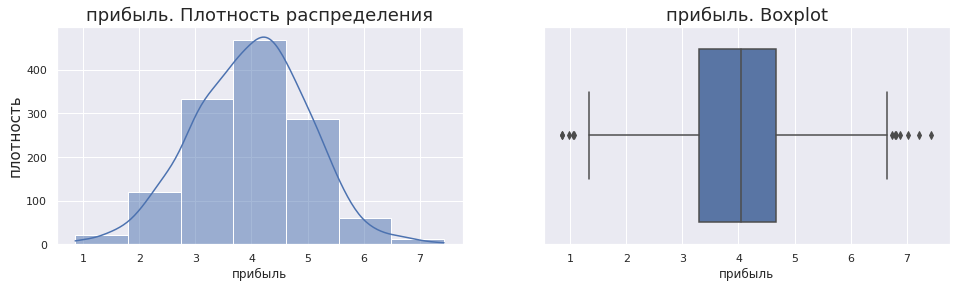

stat=0.998, p=0.258

Probably Gaussian


count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

In [42]:
show_hists_money(money[money_profit], money_profit, num_bins=math.ceil(np.log(len(money['прибыль'].unique())) + 1))
stat, p = shapiro(money[money_profit])
print('stat=%.3f, p=%.3f\n' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')
display(money[money_profit].describe())

Прибыль имеет нормальное распределение, с средним значением - 3.99, минимальным - 0.86, максимальным - 7.43

In [43]:
market_money.head()

id                период  выручка
0  215348  предпредыдущий_месяц      0.0
1  215348         текущий_месяц   3293.1
2  215348      предыдущий_месяц      0.0
3  215349  предпредыдущий_месяц   4472.0
4  215349         текущий_месяц   4971.6

In [44]:
print(market_money['период'].unique())

['предпредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


In [45]:
# создадим переменную с номерами id пользователей, которые не совершали покупок в каком-либо периоде,
# и выведем результат на экран
no_active_id = market_money.loc[(market_money['выручка'] == 0)]['id'].unique()
print(f'id пользователей с непостоянной покупательской активностью: {no_active_id}')

# создадим переменную с пользователями, которые совершали покупки в каждом из последних трёх месяцев
active_users_three_months = market_money[market_money.id.isin(no_active_id) == False]

# выведем на экран количество строк со всеми пользователями и после отсеивания
print('Всего строк market_money:', len(market_money))
print('Строк после отсеивания пользователей с непостоянной активностью:', len(active_users_three_months))

# создадим переменную с пользователями, которые не совершали покупки в каждом из последних трёх месяцев
no_active_users_three_months = market_money[market_money.id.isin(no_active_id) == True]

# выведем на экран пользователей с нопостоянной активностью
print('\nПользователи с непостоянной активностью:')
no_active_users_three_months

id пользователей с непостоянной покупательской активностью: [215348 215357 215359]
Всего строк market_money: 3900
Строк после отсеивания пользователей с непостоянной активностью: 3891

Пользователи с непостоянной активностью:


id                период  выручка
0   215348  предпредыдущий_месяц      0.0
1   215348         текущий_месяц   3293.1
2   215348      предыдущий_месяц      0.0
27  215357         текущий_месяц   5986.3
28  215357  предпредыдущий_месяц      0.0
29  215357      предыдущий_месяц      0.0
33  215359         текущий_месяц   4735.0
34  215359      предыдущий_месяц      0.0
35  215359  предпредыдущий_месяц      0.0

In [46]:
print('Количество пользователей с постоянной покупательской активностью в течение последних трёх месяцев:', 
      active_users_three_months['id'].nunique())

Количество пользователей с постоянной покупательской активностью в течение последних трёх месяцев: 1297


In [47]:
# убираем пользователей с непостоянной покупательской активностью
market_money = market_money[market_money.id.isin(no_active_id) == False]

# проверяем
market_money['id'].nunique()

1297

1297 клиентов с покупательской активностью не менее трех месяцев.

In [48]:
print('min:', market_money['выручка'].min())
print('max:', market_money['выручка'].max())

min: 2758.7
max: 106862.2


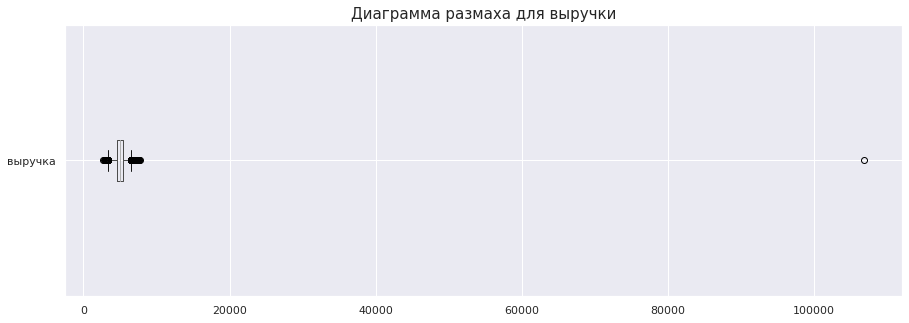

In [49]:
market_money.boxplot(column=['выручка'], figsize=(15,5), grid=True, vert=False)
plt.title('Диаграмма размаха для выручки', size=15);

как видим присутствует аномально высокое значение 106862.2

In [50]:
market_money.query('выручка == 106862.2')

id         период   выручка
98  215380  текущий_месяц  106862.2

In [51]:
market_money_big_revenue = pd.pivot_table(market_money,
                                          columns=['период'],
                                          values=['период'],
                                          index=['id']).query('id == 215380')
market_money_big_revenue

выручка                               
период предпредыдущий_месяц предыдущий_месяц текущий_месяц
id                                                        
215380               5051.0           6077.0      106862.2

Мы рассмотрели выручку данного клиента за все рассматриваемые периоды. Аномальное значение зафиксировано в текущем месяце, а в предыдущие два месяца выручка составляет 5051 и 6077. То есть, для данного покупателя такое потребительское поведение явно не свойственно. Такое значение может негативно сказать на машинном  обучении, избавимся от него.

In [52]:
id_to_delete = market_money[market_money['выручка'] == 106862.2]['id'].tolist()

# избавляемся от выброса
# уляляем данные о всех периодах для выбранного пользователя
market_money = market_money.query('id != @id_to_delete')

# проверяем
market_money['id'].nunique()

1296

#### Вывод по исследовательскому анализу

Анализируя диаграммы качественных признаков, можно сделать несколько выводов:
- Покупательская активность преимущественно осталась неизменной
- Пользователей-премиум меньше пользователей с стандартным статусом, вполне ожидаемо
- Большинство пользователй предпочитают разрешать отправлять дополнительные предложения о товаре
- Среди всех категорий можно сказать, что четверть распределения занимают товары для детей, будучи самой распространенной категорией, чего не скажешь о кухонной посуде, занимающей примерно 1/10 от всего распределения. 

Посмотрев на графики количественных признаков, можно сделать несколько важных выводов: 
- График распределения среднемесячных значений маркетинговых компаний за 6 месяцев чем-то напоминает нормальное распределение с выбросами меньше 2.0. Медиана - 4.2, макс - 6.6, мин - 0.9
- График среднемесячных значений маркетинговых компаний за текущий месяц распределен очень сжато, первый, второй и третий квартили совпадают = 4 Медиана - 4, макс - 5, мин - 3
- Длительность распределена +- равномерно среди всех пользователей, но, безусловно, имеются и отдельные случаи(например самые давние пользователи). Медиана -606, макс - 1079, мин - 110
- Распределение доли среднемесячных акционных покупок за 6 месяцев имеет два локальных максимума, в районе 0.3 и ближе к 1.0, по ящику с усами видно, что данные второго максимума сконцентрированы не так сильно как возле первого, стоит рассмотреть эти данные отдельно. Медиана - 0.24, макс - 0.99, мин - 0
- Распределение среднего количества просмотров категорий за визит имеет около нормальное распределение с медианной в 3 категории, макс = 6, мин = 1
- Распределение общего числа неоплаченных товаров из корзины за квартал похоже на распределение Пуассона за счет своей скошенности, медиана - 3, макс - 10, мин - 0
- Ошибка сервиса распределена нормально с медианной в 4 случая, макс = 9, мин = 0
- Распределение среднего количества страниц за визит имеет распределение, похожее на распределение Пуассона со скошенностью влево, Медиана - 8, макс - 20, мин - 1. 

Выбросы: 
- акционные_покупки: наблюдаются весьма высокие показатели, скорее всего это либо любители закупаться на акциях, либо пользователи, которые случайно забрели в акции(например при оформлении первой своей покупки), впрочем не столь это важно, такие наблюдения вполне объяснимы
- неоплаченные_продукты_штук_квартал: повышенные значения тоже вполне объяснимы, существуют люди, которые набирают себе корзину, затем либо забывают о товаре, либо вовсе передумывают покупать, возможно у магазина на сайте нет категории избранное, что вряд ли, скорее всего при таком раскладе медианное значение было бы значительно выше
-  Аномальное значение зафиксировано в текущем месяце столбца 'выручка', в предыдущие два месяца выручка составляет 5051 и 6077. То есть, для данного покупателя такое потребительское поведение явно не свойственно.

## Объединенеие таблиц

Учитывая, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов, в итоговой таблице для каждого периода сделаем отдельный столбец.

In [53]:
# с помощью собственной функции преобразуем категориальные значения 'покупательская_активность' в числовые
# 'Снизилась' преобразуем в 1
# 'Прежний уровень' преобразуем в 0

# зададим переменные для преобразования
cat_value_one = 'Снизилась'
cat_value_two = 'Прежний уровень'

# перезапишем столбец 'покупательская_активность' с помощью функции to_binary_func
market_file['покупательская_активность'] = market_file['покупательская_активность'].apply(main.to_binary_func)

# проверяем
print(market_file['покупательская_активность'].value_counts())
market_file.head()

0    802
1    498
Name: покупательская_активность, dtype: int64


id  покупательская_активность тип_сервиса разрешить_сообщать  \
0  215348                          1     премиум                 да   
1  215349                          1     премиум                 да   
2  215350                          1    стандарт                нет   
3  215351                          1    стандарт                 да   
4  215352                          1    стандарт                нет   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

#### Объединяем таблицы

In [54]:
# выделим из df_market_money и df_market_time отдельные датарфеймы для каждого периода
market_money_tek_mes = (market_money
                        .query('период == "текущий_месяц"')
                        .drop(['период'], axis=1)
                        .rename(columns={'выручка': 'выручка_текущий_месяц'}))

market_money_pre_mes = (market_money
                        .query('период == "предыдущий_месяц"')
                        .drop(['период'], axis=1)
                        .rename(columns={'выручка': 'выручка_предыдущий_месяц'}))

market_money_prepre_mes = (market_money
                           .query('период == "предпредыдущий_месяц"')
                           .drop(['период'], axis=1)
                           .rename(columns={'выручка': 'выручка_предпредыдущий_месяц'}))

market_time_tek_mes = (market_time
                       .query('период == "текущий_месяц"')
                       .drop(['период'], axis=1)
                       .rename(columns={'минут': 'минут_текущий_месяц'}))

market_time_pre_mes = (market_time
                       .query('период == "предыдущий_месяц"')
                       .drop(['период'], axis=1)
                       .rename(columns={'минут': 'минут_предыдущий_месяц'}))

In [55]:
# объединяем датафреймы
merged_final = (market_file
                .merge(market_money_tek_mes, on='id')
                .merge(market_money_pre_mes, on='id')
                .merge(market_money_prepre_mes, on='id')
                .merge(market_time_tek_mes, on='id')
                .merge(market_time_pre_mes, on='id')
                .reset_index(drop=True))

# проверяем
print(merged_final.shape)
merged_final.head()

(1296, 18)


id  покупательская_активность тип_сервиса разрешить_сообщать  \
0  215349                          1     премиум                 да   
1  215350                          1    стандарт                нет   
2  215351                          1    стандарт                 да   
3  215352                          1    стандарт                нет   
4  215353                          1    стандарт                 да   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 4.4                     4           819               0.75   
1                 4.9                     3           539               0.14   
2                 3.2                     5           896               0.99   
3                 5.1                     3          1064               0.94   
4                 3.3                     4           762               0.26   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    4   
1    Домашний текстиль                                    5   
2     Товары для детей                                    5   
3     Товары для детей                                    3   
4    Домашний текстиль                                    4   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
0                                   4               2                 5   
1                                   2               1                 5   
2                                   0               6                 4   
3                                   2               3                 2   
4                                   1               1                 4   

   выручка_текущий_месяц  выручка_предыдущий_месяц  \
0                 4971.6                    5216.0   
1                 5058.4                    5457.5   
2                 6610.4                    6158.0   
3                 5872.5                    5807.5   
4                 5388.5                    4738.5   

   выручка_предпредыдущий_месяц  минут_текущий_месяц  минут_предыдущий_месяц  
0                        4472.0                   10                      12  
1                        4826.0                   13                       8  
2                        4793.0                   13                      11  
3                        4594.0                   11                       8  
4                        5124.0                   10                      10

- Перед объединением таблиц преобразовали признак покупательская_активность в датафрейме market_file - категориальные значения Снизилась и Прежний уровень изменили на 1 и 0. 
- В итоговой таблице для каждого периода из market_money и market_time сделали отдельный столбец.

##  Корреляционный анализ

Используем библиотеку phik для подсчёта корреляции между признаками разных типов данных.

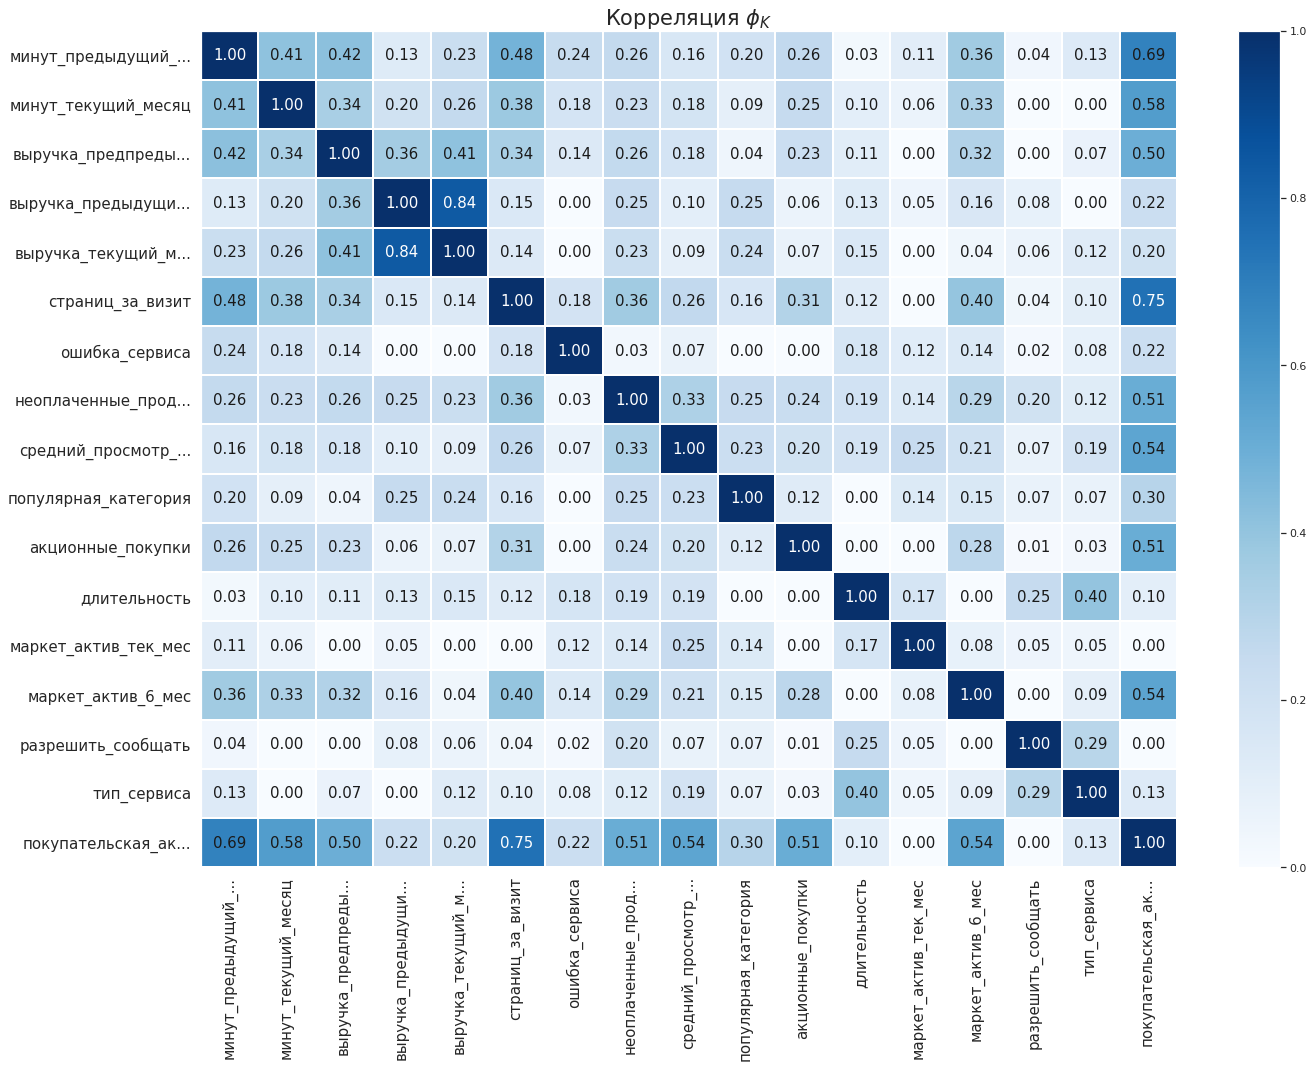

In [56]:
# строим матрицу корреляции
phik_overview = (
    merged_final
    .drop('id', axis=1)
    .phik_matrix(verbose=False))

# визуализируем матрицу и выводим на экран
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

#### Вывод по еорреляционному анализу

- Целевой признак: покупательская_активность. Остальные - входные. 
- О мультиколлинеарности свидетельствует значение коэффициента корреляции от 0.9 до 0.95 по модулю. Соответственно, можем сделать вывод, что в нашем случае мультиколлинеарность отсутствует.

## Использование пайплайнов

#### Проверка дисбаланса классов

Соотношение классов признака "покупательская_активность" (в %):
0    0.62
1    0.38
Name: покупательская_активность, dtype: float64


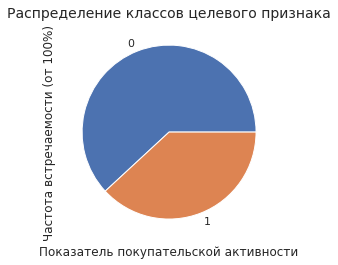

In [57]:
# проверяем целевой признак на дисбаланс классов
print('Соотношение классов признака "покупательская_активность" (в %):')
print(round(merged_final.покупательская_активность.value_counts(normalize=True), 2))

# визуализируем на графике
merged_final.покупательская_активность.value_counts(normalize=True).plot(kind='pie')
plt.title('Распределение классов целевого признака', size=14)
plt.xlabel('Показатель покупательской активности', size=12)
plt.ylabel('Частота встречаемости (от 100%)', size=12)
plt.xticks(rotation=0);

Соотношение классов в целевом признаке непропорционально - 62% (прежний уровень, класс 0) против 38% (снизилась, класс 1).
Поэтому, чтобы сохранить пропорцию классов в тренировочной и тестовой выборках, используем стратификацию.

Разделим данные на выборки с учётом стратификации по целевому признаку.

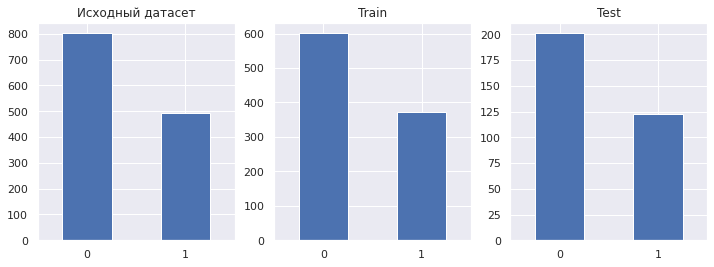

In [58]:
# выделяем в отдельные переменные целевой признак и входные признаки
X = merged_final.drop(columns=['покупательская_активность', 'id'])
y = merged_final['покупательская_активность']

# разбиваем данные на выборки с учётом стратификации по целевому признаку
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE, 
    test_size=TEST_SIZE, 
    stratify=y
) 

# визуализируем баланс целевого признака в выборках
fig, ax = plt.subplots(1,3, figsize=(12,4))
y.value_counts().plot(kind='bar', ax=ax[0], rot=0)
ax[0].set_title("Исходный датасет")
y_train.value_counts().plot(kind='bar', ax=ax[1], rot=0)
ax[1].set_title("Train")
y_test.value_counts().plot(kind='bar', ax=ax[2], rot=0)
ax[2].set_title("Test")
plt.show()

Разделение на выборки с учетом дисбаланса классов целевого признака прошло корректно.

#### Создание пайплайна

Создадим пайплайн, который выберет лучшую комбинацию модели и гиперпараметров. 

- DecisionTreeClassifier() с гиперпараметрами: max_depth от 2 до 4 включительно, max_features от 2 до 4 включительно. 

- KNeighborsClassifier() с гиперпараметром: n_neighbors от 2 до 4 включительно. 

- LogisticRegression() - с решателем solver='liblinear' и лассо-регуляризацией с гиперпараметром,С от 1 до 4 включительно. 

- SVC() - с линейным ядром kernel='linear' с гиперпараметром, перебор «силы» модели для ядра от 1 до 9 включительно.

После выбора лучшей модели рассчитаем метрику ROC-AUC на тренировочной и тестовой выборках.
Выбираем именно ROC-AUC, так как данная метрика лучше всего подойдёт для задачи бинарной классификации с несбалансированным целевым признаком.

In [59]:
# создаём списки с названиями признаков для кодирования и масштабирования/стандартизации
# признаки для кодирования OneHotEncoder
ohe_columns = ['популярная_категория']

# признаки для кодирования OrdinalEncoder
ord_columns = ['тип_сервиса', 'разрешить_сообщать']

# признаки для масштабирования/стандартизации
num_columns = ['маркет_актив_6_мес', 
               'маркет_актив_тек_мес', 
               'длительность', 
               'акционные_покупки', 
               'средний_просмотр_категорий_за_визит', 
               'неоплаченные_продукты_штук_квартал', 
               'ошибка_сервиса', 
               'страниц_за_визит', 
               'выручка_текущий_месяц', 
               'выручка_предыдущий_месяц', 
               'выручка_предпредыдущий_месяц', 
               'минут_текущий_месяц', 
               'минут_предыдущий_месяц']

# добавляем Ohe-кодирование в пайплайн
ohe_pipe = Pipeline([('ohe',
                      OneHotEncoder(drop='first',
                                    handle_unknown='error',
                                    sparse_output=False))]
                   )

# добавляем Ordinal-кодирование в пайплайн
ord_pipe = Pipeline(
    [('ord', OrdinalEncoder(
    categories=[
        ['стандарт', 'премиум'], 
        ['да', 'нет']
    ], 
    handle_unknown='use_encoded_value', 
    unknown_value=np.nan))
                    ]
                   )

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн для обучения модели
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  
    },
    
]

In [60]:
# выберем лучшую модель и параметры с помощью RandomizedSearchCV()
# количество комбинаций гиперпараметров поставим 5
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
# обучаем лучшую модель на тренировочных данных
randomized_search.fit(X_train, y_train)

# выводим на экран лучшую модель, её параметры и метрику ROC-AUC на тренировочной выборке
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на валидационной выборке:', randomized_search.best_score_)
print ('Лучшие гиперпараметры:', randomized_search.best_params_)
y_test_pred_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_proba[:, 1])}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                                                               'премиум'],
                                                                                              ['да',
                    

In [61]:
# преобразовываем результаты в датафрейм и выводим результаты на экран
pd.DataFrame(randomized_search.cv_results_)[
    ['std_test_score', 'rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')

std_test_score  rank_test_score  \
5        0.016762                1   
1        0.016742                2   
3        0.017208                3   
0        0.011744                4   
2        0.020894                5   
4        0.020894                5   
9        0.020894                5   
6        0.041153                8   
7        0.043252                9   
8        0.043607               10   

                                                            param_models  \
5  LogisticRegression(penalty='l1', random_state=42, solver='liblinear')   
1  LogisticRegression(penalty='l1', random_state=42, solver='liblinear')   
3  LogisticRegression(penalty='l1', random_state=42, solver='liblinear')   
0                                                 KNeighborsClassifier()   
2                                DecisionTreeClassifier(random_state=42)   
4                                DecisionTreeClassifier(random_state=42)   
9                                DecisionTreeClassifier(random_state=42)   
6                                DecisionTreeClassifier(random_state=42)   
7                                DecisionTreeClassifier(random_state=42)   
8                                DecisionTreeClassifier(random_state=42)   

   mean_test_score  \
5         0.898248   
1         0.896593   
3         0.896347   
0         0.863675   
2         0.838702   
4         0.838702   
9         0.838702   
6         0.784136   
7         0.770902   
8         0.696723   

                                                                                                                                          params  
5         {'preprocessor__num': MinMaxScaler(), 'models__C': 1, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}  
1         {'preprocessor__num': MinMaxScaler(), 'models__C': 2, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}  
3         {'preprocessor__num': MinMaxScaler(), 'models__C': 3, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}  
0                                            {'preprocessor__num': StandardScaler(), 'models__n_neighbors': 2, 'models': KNeighborsClassifier()}  
2    {'preprocessor__num': RobustScaler(), 'models__max_features': 4, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}  
4  {'preprocessor__num': StandardScaler(), 'models__max_features': 4, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}  
9    {'preprocessor__num': MinMaxScaler(), 'models__max_features': 4, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}  
6  {'preprocessor__num': StandardScaler(), 'models__max_features': 3, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}  
7    {'preprocessor__num': MinMaxScaler(), 'models__max_features': 2, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}  
8    {'preprocessor__num': MinMaxScaler(), 'models__max_features': 3, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}

#### Вывод

Построили пайплайн и выбрали лучшую комбинацию модели и гиперпараметров с использованием четырёх моделей.
Лучшая модель:
- LogisticRegression. 
- Метрика ROC-AUC на тестовой выборке: 0.91

## Анализ важности признаков

Оценка важности признаков лучшей модели и построение графика важности с помощью метода SHAP. 

#### Обучаем лучшую модель с лучшими параметрами

In [62]:
# кодируем категориальные признаки с помощью OneHotEncoder()
ohe_encoder = OneHotEncoder(sparse_output=False, drop='first')
X_train_ohe = ohe_encoder.fit_transform(X_train[ohe_columns])
X_test_ohe = ohe_encoder.transform(X_test[ohe_columns])
ohe_encoder_col_names = ohe_encoder.get_feature_names_out()

# кодируем категориальные признаки с помощью OrdinalEncoder()
ord_encoder = OrdinalEncoder()
X_train_ord = ord_encoder.fit_transform(X_train[ord_columns])
X_test_ord = ord_encoder.transform(X_test[ord_columns])
ord_encoder_col_names = ord_encoder.get_feature_names_out()

# масштабируем количественные признаки с помощью StandardScaler()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_encoder_col_names)

X_train_ord = pd.DataFrame(X_train_ord, columns=ord_encoder_col_names)
X_test_ord = pd.DataFrame(X_test_ord, columns=ord_encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
X_train_first = pd.concat([X_train_ohe, X_train_ord], axis=1)
X_train_final = pd.concat([X_train_first, X_train_scaled], axis=1)

X_test_first = pd.concat([X_test_ohe, X_test_ord], axis=1)
X_test_final = pd.concat([X_test_first, X_test_scaled], axis=1)

# проверяем размерности выборок
print('Размерности выборок:')

shape_data = {'Выборка': ['X_train_final', 'X_test_final', 'y_train', 'y_test'], 
              'Размер': [X_train_final.shape, X_test_final.shape, y_train.shape, y_test.shape]} 

display(pd.DataFrame(shape_data))

Размерности выборок:


Выборка     Размер
0  X_train_final  (972, 20)
1   X_test_final  (324, 20)
2        y_train     (972,)
3         y_test     (324,)

In [63]:
best_model = randomized_search.best_estimator_.named_steps['models']

In [1]:
%%time
# преобразую данные
x_Train = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
# вытаскиваю лучшую модель
explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'], x_Train)
# преобразую данные
x_Test = pipe_final.named_steps['preprocessor'].transform(X_test)
# вытаскиваю названия столбцов
x_Test = pd.DataFrame(x_Test, columns = randomized_search.best_estimator_['preprocessor'].get_feature_names_out())
shap_values = explainer.shap_values(x_Test.iloc[0:1000,:])
shap.force_plot(explainer.expected_value, shap_values, x_Test.iloc[0:1000,:])

NameError: name 'pipe_final' is not defined

In [2]:
shap.summary_plot(shap_values, x_Test.iloc[0:1000,:])

NameError: name 'shap' is not defined

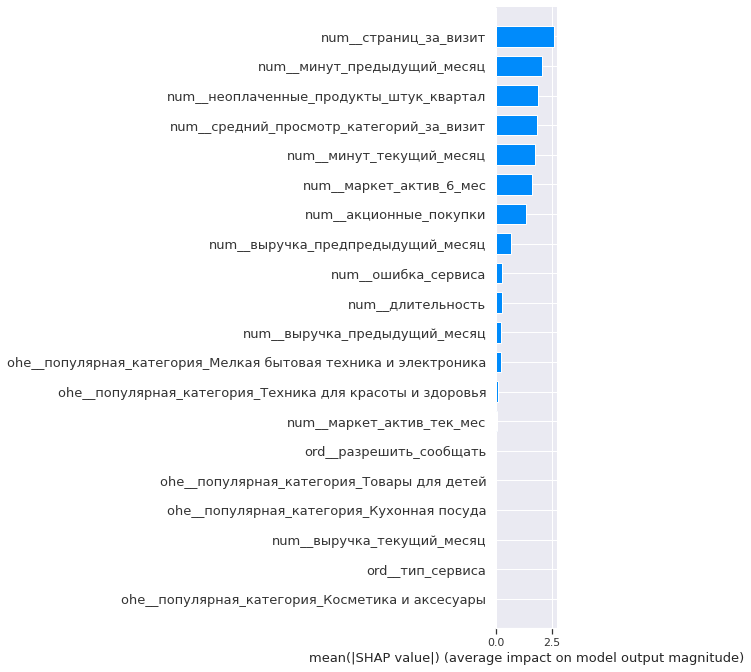

In [66]:
shap.summary_plot(shap_values, x_Test, plot_type='bar')

In [67]:
display(x_Test.head(5))

ohe__популярная_категория_Косметика и аксесуары  \
0                                              0.0   
1                                              0.0   
2                                              0.0   
3                                              0.0   
4                                              0.0   

   ohe__популярная_категория_Кухонная посуда  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   

   ohe__популярная_категория_Мелкая бытовая техника и электроника  \
0                                                             0.0   
1                                                             0.0   
2                                                             0.0   
3                                                             0.0   
4                                                             1.0   

   ohe__популярная_категория_Техника для красоты и здоровья  \
0                                                       1.0   
1                                                       0.0   
2                                                       0.0   
3                                                       0.0   
4                                                       0.0   

   ohe__популярная_категория_Товары для детей  ord__тип_сервиса  \
0                                         0.0               0.0   
1                                         1.0               1.0   
2                                         0.0               1.0   
3                                         0.0               1.0   
4                                         0.0               0.0   

   ord__разрешить_сообщать  num__маркет_актив_6_мес  \
0                      0.0                -0.169629   
1                      1.0                -2.866015   
2                      0.0                -0.968558   
3                      0.0                -0.768826   
4                      1.0                 1.228498   

   num__маркет_актив_тек_мес  num__длительность  num__акционные_покупки  \
0                  -0.034940          -0.003856               -0.678649   
1                  -0.034940           0.307182                2.517826   
2                  -0.034940          -0.474402               -0.759573   
3                  -1.450017           1.794585                0.130585   
4                  -0.034940          -1.834199                2.720134   

   num__средний_просмотр_категорий_за_визит  \
0                                  2.045527   
1                                 -0.183455   
2                                  0.559539   
3                                  0.559539   
4                                 -1.669444   

   num__неоплаченные_продукты_штук_квартал  num__ошибка_сервиса  \
0                                -0.927589            -0.099707   
1                                 1.542593            -1.646221   
2                                -0.433553             1.962313   
3                                 0.060484             0.415798   
4                                -0.433553            -0.615212   

   num__страниц_за_визит  num__выручка_текущий_месяц  \
0               0.961202                   -2.320463   
1              -0.557143                   -1.271572   
2               0.455087                    1.304666   
3              -0.557143                    1.807872   
4              -0.304085                    0.635946   

   num__выручка_предыдущий_месяц  num__выручка_предпредыдущий_месяц  \
0                      -1.405144                           0.214194   
1                      -2.013227                          -0.540665   
2                       0.699537                          -0.808993   
3                       2.359246                           0.453036   
4                       0.193040

In [68]:
y_pred = best_model.predict(X_test_final)
#Cохраним предсказания принадлежности к классам для тестовых данных
clf_best_probas = best_model.predict_proba(X_test_final)[:,1]

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


#### Построим матрицу ошибок с помощью ConfusionMatrixDisplay()

In [69]:
x = X_test_final.values

#### Составим рейтинг признаков, которые вносят наибольший вклад в модель


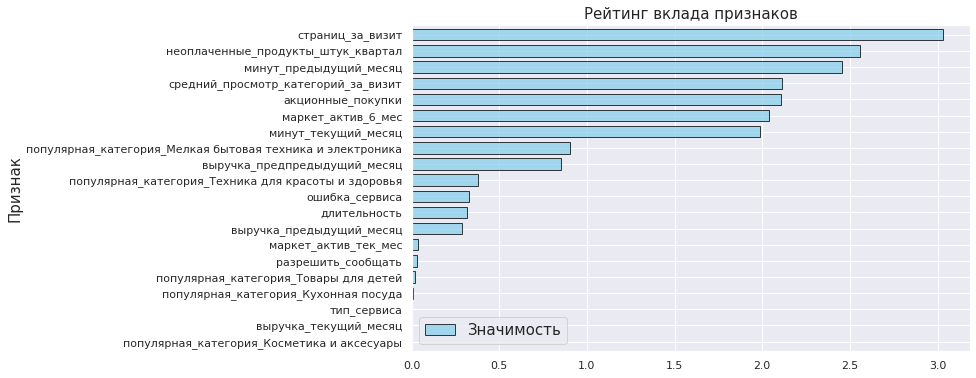

In [70]:
# отложим значения коэффициентов на графике
coeffs = best_model.coef_[0]
feature_importance = pd.DataFrame({'Признак': X_train_final.columns, 'Значимость': np.abs(coeffs)})
feature_importance = feature_importance.sort_values(by='Значимость', ascending=True)
feature_importance.plot(x='Признак', 
                        y='Значимость', 
                        kind='barh', 
                        figsize=(10, 6), 
                        ec='black', 
                        alpha=0.75, 
                        lw=1, color='skyblue', 
                        width=0.7)
plt.legend(prop={'size': 15})
plt.ylabel('Признак', size=15)
plt.title('Рейтинг вклада признаков', size=15)
plt.show()

In [71]:
# веса и отклонения
print(best_model.coef_)
print(line_1)
print(best_model.intercept_)

[[ 0.         -0.00750091 -0.90356808 -0.37763769 -0.01683471  0.
  -0.03011741 -2.03648737  0.03643795  0.31616704  2.10463623 -2.11328292
   2.55926534 -0.32738834 -3.03210231  0.          0.28713865 -0.85336581
  -1.98498663 -2.45607847]]
*******************************************************************************************************************************
[3.94996286]


Исходя из графика, выделим ТОП-5 признаков с наибольшим вкладом в модель:

- популярная_категория_Мелкая бытовая техника и электроника
- страниц_за_визит
- средний_просмотр_категорий_за_визит 

Признак с наименьшим вкладом в модель:
- тип_сервиса

#### Отберём 10 лучших признаков на основе статистических тестов с помощью SelectKBest()  
Для отбора будем использовать f_classif - тест на основании линейной зависимости между двумя случайными признаками.

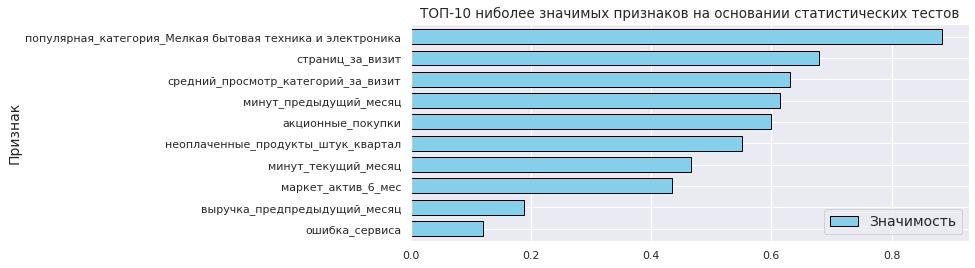

In [72]:
# выбираем селектор с нужными параметрами
# рассмотрим 10 признаков
selector = SelectKBest(f_classif, k=10)

# создаём новый набор данных (10 наиболее важных признаков из выборки)
X_new = selector.fit_transform(X_train_final, y_train)

# формируем выборки с лучшими признаками
features_names = X_train_final.columns[selector.get_support(indices=True)]
X_train_new = X_train_final[list(features_names)]
X_test_new = X_test_final[list(features_names)]

# обучаем модель
clf_best_fit_new = LogisticRegression(penalty='l1', C=2, solver='liblinear', random_state=42)
clf_best_fit_new.fit(X_train_new, y_train)

# отложим значения коэффициентов на графике
coefficients = clf_best_fit_new.coef_[0]
feature_importance = pd.DataFrame({'Признак': features_names, 'Значимость': np.abs(coefficients)})
feature_importance = feature_importance.sort_values(by='Значимость', ascending=True)
feature_importance.plot(x='Признак', 
                        y='Значимость', 
                        kind='barh', 
                        figsize=(10, 4), 
                        color='skyblue', 
                        ec='black', 
                        lw=1, 
                        width=0.7)
plt.legend(prop={'size': 14})
plt.ylabel('Признак', size=14)
plt.title('ТОП-10 ниболее значимых признаков на основании статистических тестов', size=13.5)
plt.show()


Статистические тесты дали следующий результат (ТОП-3):

- популярная_категория_Мелкая бытовая техника и электроника
- страниц_за_визит
- средний_просмотр_категорий_за_визит

#### Проверка permutation importance с F1-мерой

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn

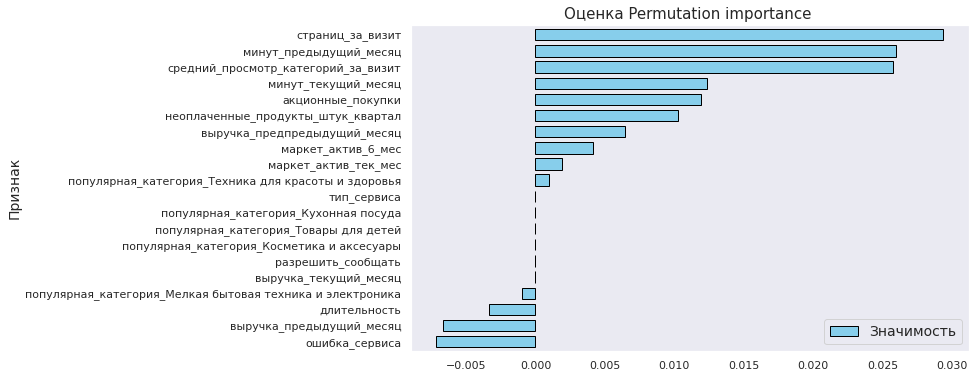

In [73]:
# выбираем новый селектор с нужными параметрами
selector_new = SelectKBest(f_classif, k=20)
X_new_new = selector_new.fit_transform(X_train_final, y_train)
features_names_new = X_train_final.columns[selector_new.get_support(indices=True)]

# функция расчёта оценки качества
def custom_f1(model, X, y):
    y_pred = model.predict(X)
    score = f1_score(y, y_pred)
    return score

result_new = permutation_importance(best_model, X_test_final, y_test, scoring=custom_f1)

feature_importance_new = pd.DataFrame({'Признак': features_names_new, 'Значимость': result_new['importances_mean']})
feature_importance_new = feature_importance_new.sort_values('Значимость', ascending=True)
sns.set_style('dark')
feature_importance_new.plot(x='Признак', 
                            y='Значимость', 
                            kind='barh', 
                            figsize=(10, 6), 
                            color='skyblue', 
                            ec='black', 
                            lw=1, 
                            width=0.7)
plt.legend(prop={'size': 14})
plt.ylabel('Признак', size=14)
plt.title('Оценка Permutation importance ', size=15)
plt.show()

Перемешивание значений выявило следующих фаворитов:

- средний_просмотр_категорий_за_визит
- минут_предыдущий_месяц
- минут_текущий_месяц

#### Изучим важность признаков методом SHAP

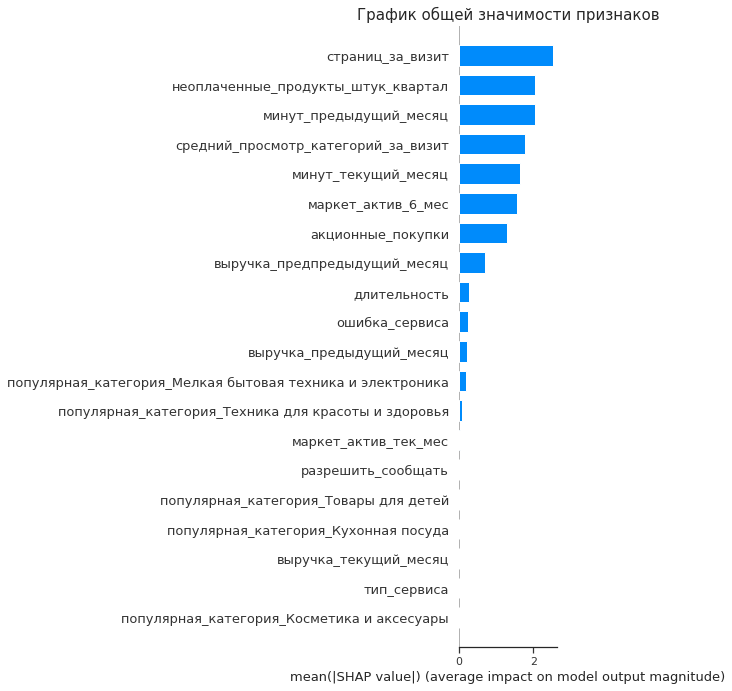

*******************************************************************************************************************************


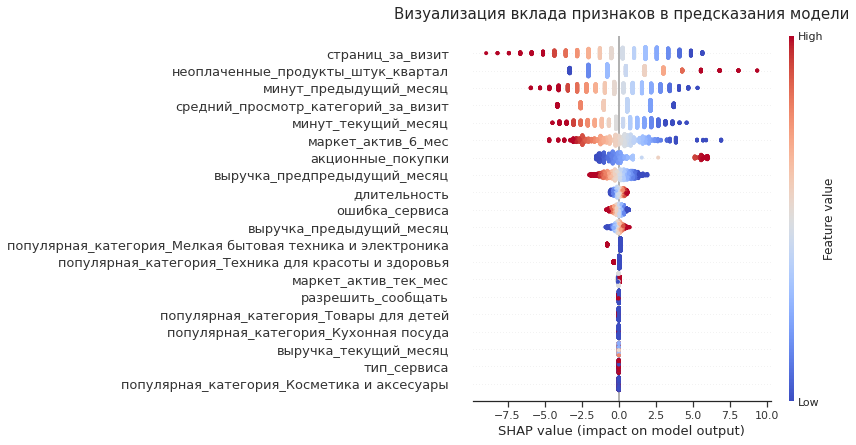

In [74]:
# строим график общей значимости признаков для лучшей модели
explainer = shap.Explainer(best_model, X_train_final)
shap_values = explainer(X_train_final)
sns.set_style('white')
shap.summary_plot(shap_values, plot_type="bar", max_display=20, show=False)
plt.title('График общей значимости признаков', size=15)
plt.show()
print(line_1)

# визуализируем вклад признаков на диаграмме
shap.summary_plot(shap_values, X_train_final, show=False, plot_size=[12, 6], cmap='coolwarm')
plt.title('Визуализация вклада признаков в предсказания модели', size=15, y=1.03)
plt.show()

Исходя из анализа SHAP-значений, наиболее значимые признаки:  
- страниц_за_визит 
- средний_просмотр_категорий_за_визит
- минут_предыдущий_месяц  

Исходя из визуализации вклада признаков:
- высокие значения "страниц_за_визит" и "минут_предыдущий_месяц" уменьшают shap значение объектов и увеличивают вероятность принадлежности к классу 0. 
- высокие значения "акционные_покупки" увеличивают значения SHAP-объектов и увеличивают вероятность принадлежности наблюдений к классу 1.

#### Изучим примеры неверно классифицированных объектов

Для этого отфильтруем такие наблюдения по двум критериям:

- для неверно классифицированных классов 1

Истинное значение целевого признака - 1  
Вероятность принадлежность к классу 1 была меньше или равно 0.5  
- для неверно классифицированных классов 0

Истинное значение целевого признака - 0  
Вероятность принадлежность к классу 0 была оценена выше 0.5

In [75]:
# формируем столбцы
X_test_final['y_test'] = y_test.tolist()
X_test_final['y_pred'] = y_pred.tolist()
X_test_final['predict_proba'] = clf_best_probas

# выводим на экран неверно классифицированные классы 1
display(X_test_final[(X_test_final['y_test']==1)
                     & (X_test_final['y_pred']==0)
                     & (X_test_final['predict_proba']<=0.5)][['y_test', 
                                                            'y_pred',
                                                            'predict_proba',
                                                            'страниц_за_визит',
                                                            'акционные_покупки']].sort_values(by='predict_proba'))
# выводим на экран неверно классифицированные классы 0 
display(X_test_final[(X_test_final['y_test']==0)
                     & (X_test_final['y_pred']==1)
                     & (X_test_final['predict_proba']>0.5)][['y_test', 
                                                            'y_pred', 
                                                            'predict_proba',
                                                            'страниц_за_визит',
                                                            'акционные_покупки']].sort_values(ascending=False, 
                                                                                              by='predict_proba'))

y_test  y_pred  predict_proba  страниц_за_визит  акционные_покупки
275       1       0       0.000002          1.214259          -0.719111
111       1       0       0.000169          0.202029          -0.597726
272       1       0       0.002262          0.202029          -0.719111
27        1       0       0.002297          2.226488          -0.557264
24        1       0       0.007005          1.720374          -0.314494
201       1       0       0.010083          0.961202          -0.638188
167       1       0       0.020077          1.214259          -0.678649
297       1       0       0.022969          1.973431          -0.071724
314       1       0       0.050075          0.202029          -0.435879
83        1       0       0.169891          0.455087          -0.354956
200       1       0       0.183022          1.214259          -0.435879
256       1       0       0.226443         -0.304085          -0.719111
77        1       0       0.256169          0.708144          -0.638188
184       1       0       0.276863          0.455087          -0.476341
136       1       0       0.378892          0.708144          -0.314494

y_test  y_pred  predict_proba  страниц_за_визит  акционные_покупки
277       0       1       0.999913         -1.316315          -0.354956
96        0       1       0.999788         -1.316315          -0.597726
242       0       1       0.999676          0.455087          -0.354956
227       0       1       0.999582          1.214259          -0.274032
95        0       1       0.999566         -1.063258          -0.678649
..      ...     ...            ...               ...                ...
82        0       1       0.538773         -0.051028          -0.314494
285       0       1       0.535412          0.455087          -0.759573
186       0       1       0.529528         -0.810200          -0.597726
191       0       1       0.527326         -0.051028           0.332893
306       0       1       0.514011          1.720374          -0.314494

[70 rows x 5 columns]

##### Теперь оценим вклад каждого признака в ошибочно классифицированные объекты

Index: 24


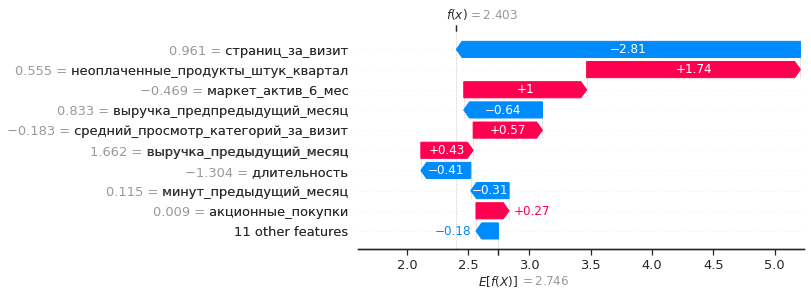

*******************************************************************************************************************************
Index: 27


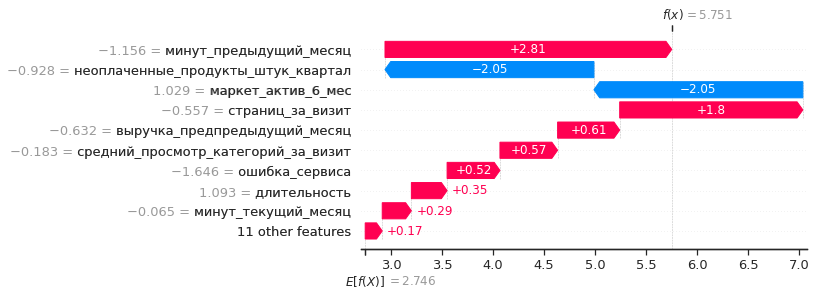

*******************************************************************************************************************************
Index: 77


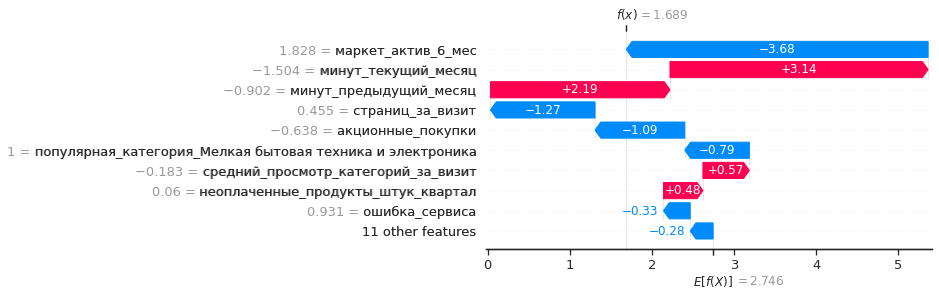

*******************************************************************************************************************************
Index: 83


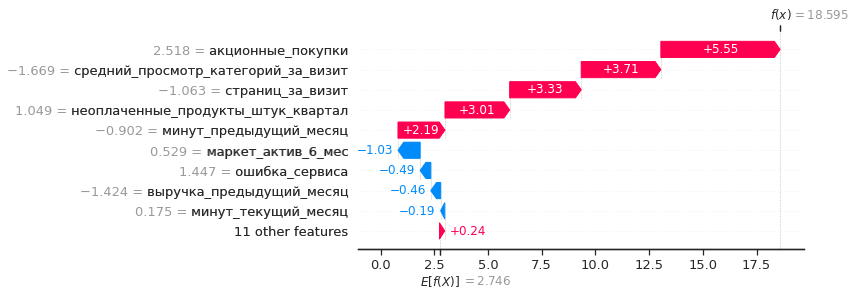

*******************************************************************************************************************************
Index: 111


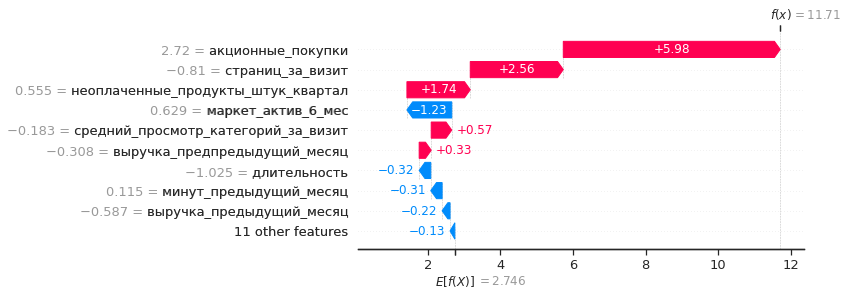

*******************************************************************************************************************************
Index: 136


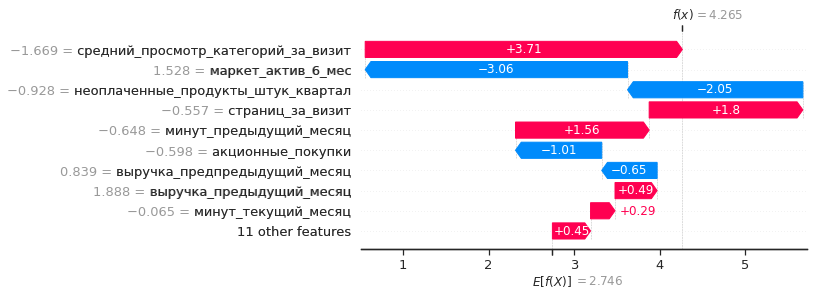

*******************************************************************************************************************************
Index: 167


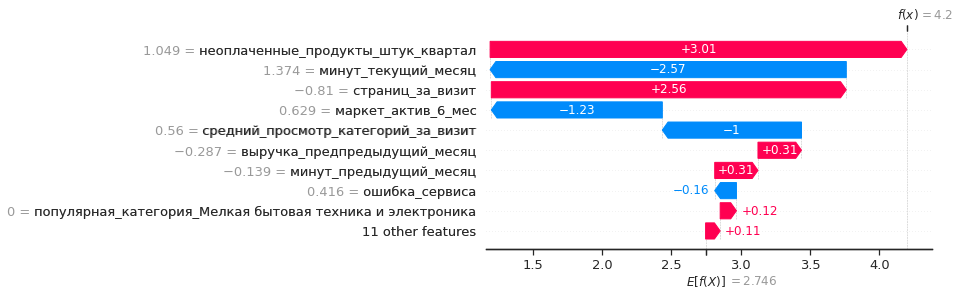

*******************************************************************************************************************************
Index: 184


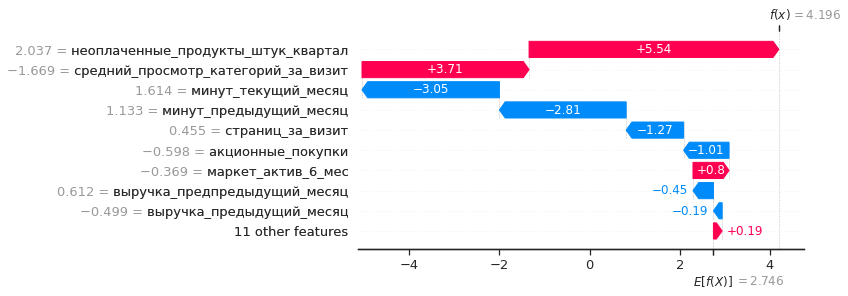

*******************************************************************************************************************************
Index: 200


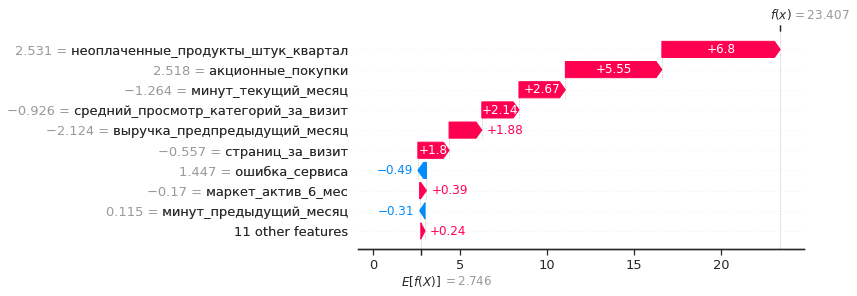

*******************************************************************************************************************************
Index: 201


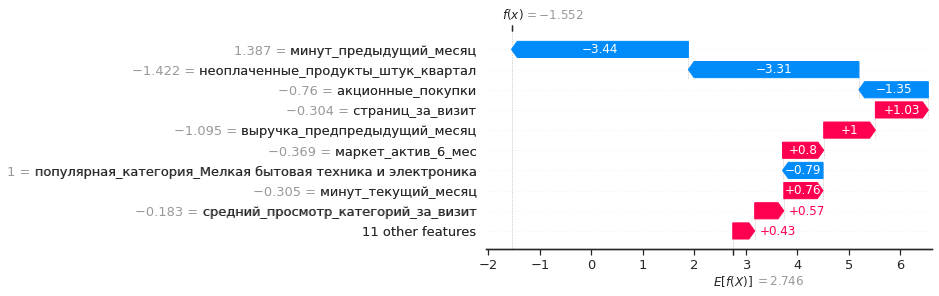

*******************************************************************************************************************************
Index: 256


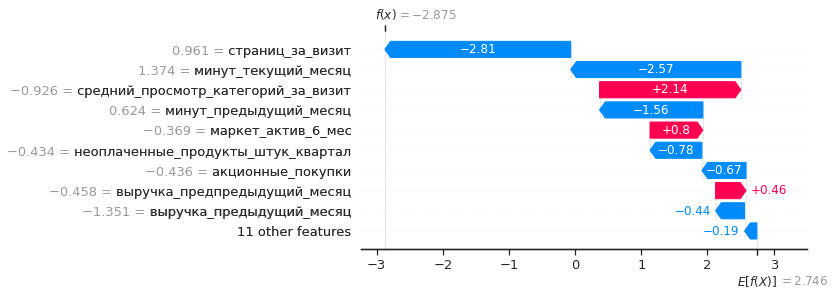

*******************************************************************************************************************************
Index: 272


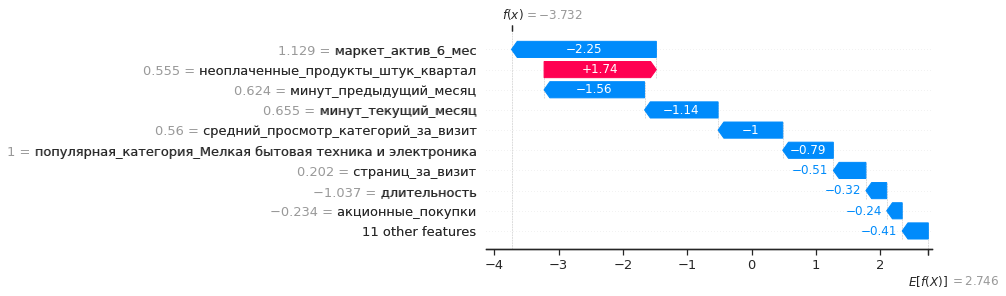

*******************************************************************************************************************************
Index: 275


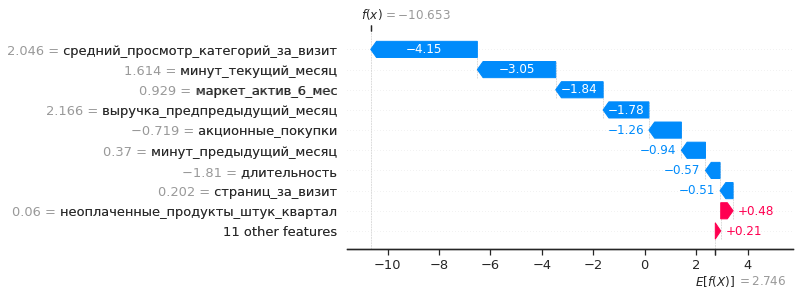

*******************************************************************************************************************************
Index: 297


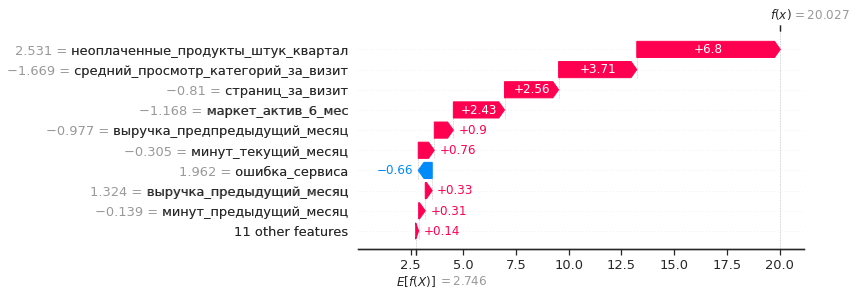

*******************************************************************************************************************************
Index: 314


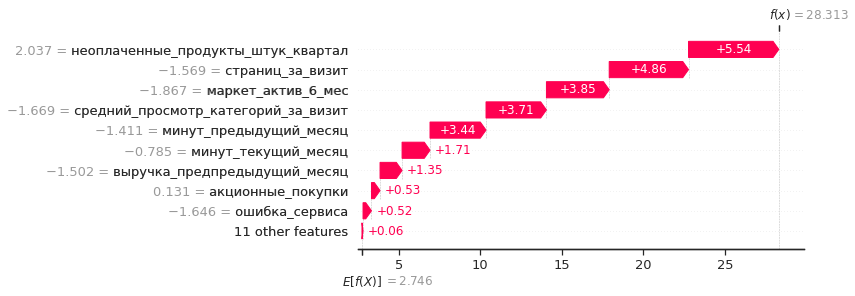

*******************************************************************************************************************************


In [76]:
# в отдельную переменную сохраняем индексы ошибочно присвоенных классов 0
indexes_one = X_test_final.index[(X_test_final['y_test']==1) & (X_test_final['y_pred']==0)].tolist()

# через цикл визуализируем вклады признаков для каждого объекта
for i in indexes_one:
    print('Index:', i)
    fig = plt.figure()
    shap.plots.waterfall(shap_values[i], show=False)
    plt.gcf().set_size_inches(8, 4)
    plt.show()
    print(line_1)

Index: 8


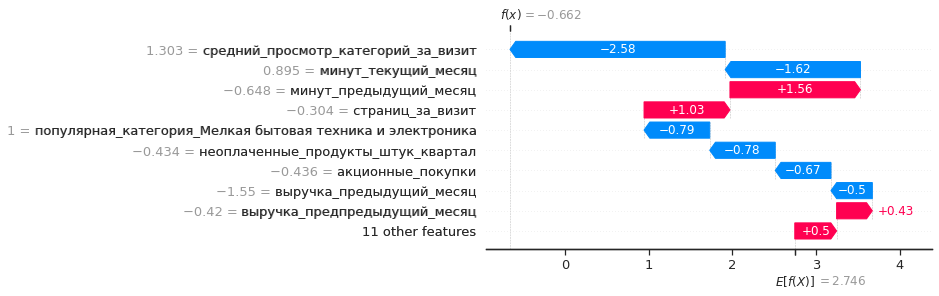

*******************************************************************************************************************************
Index: 13


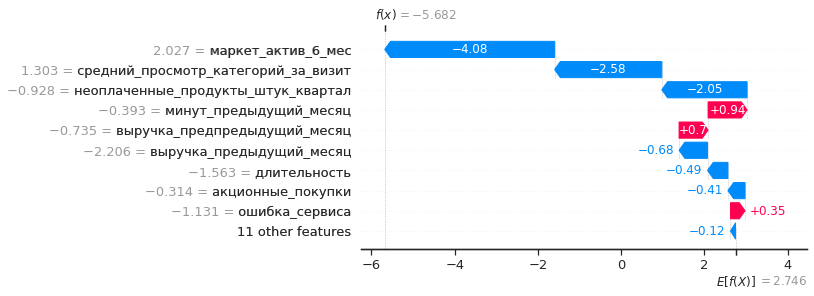

*******************************************************************************************************************************
Index: 19


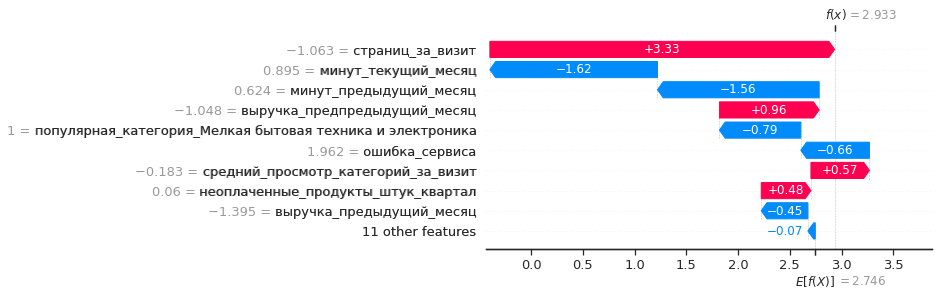

*******************************************************************************************************************************
Index: 31


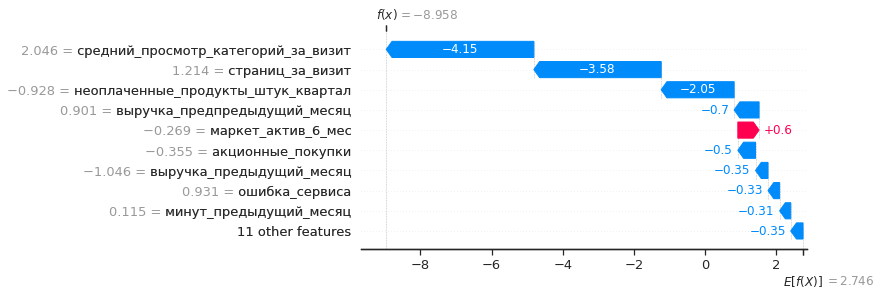

*******************************************************************************************************************************
Index: 32


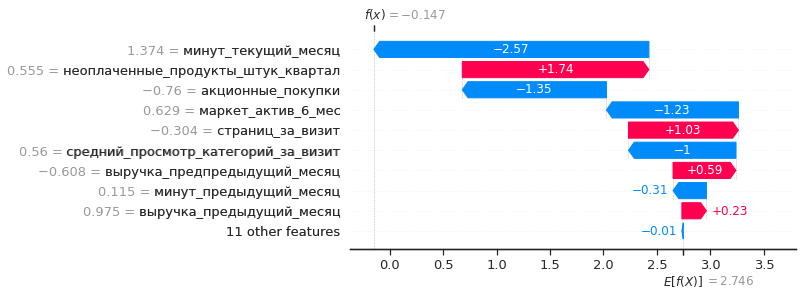

*******************************************************************************************************************************
Index: 41


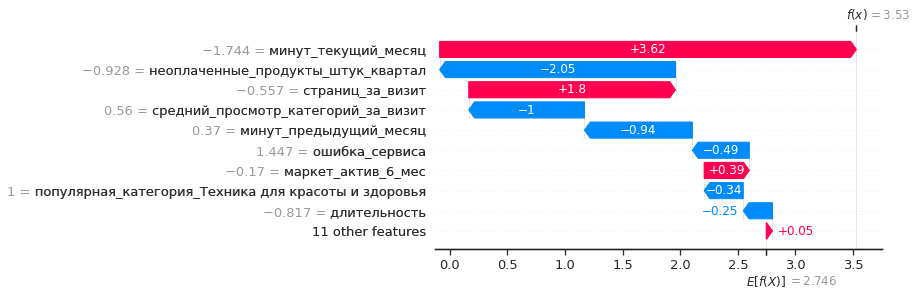

*******************************************************************************************************************************
Index: 43


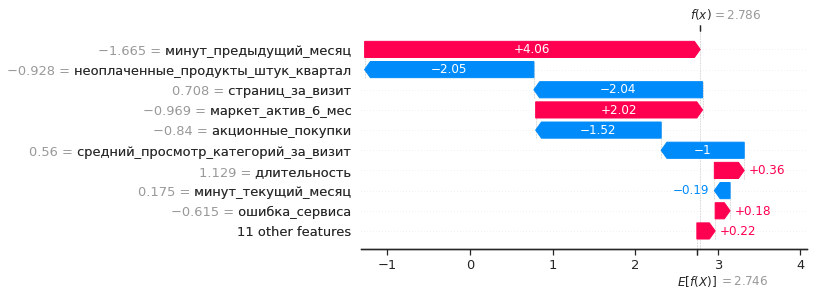

*******************************************************************************************************************************
Index: 44


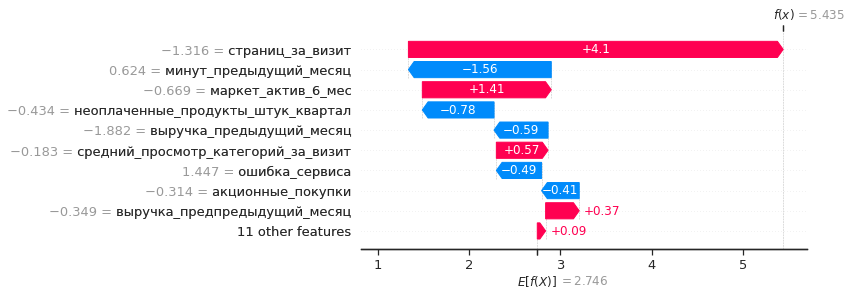

*******************************************************************************************************************************
Index: 45


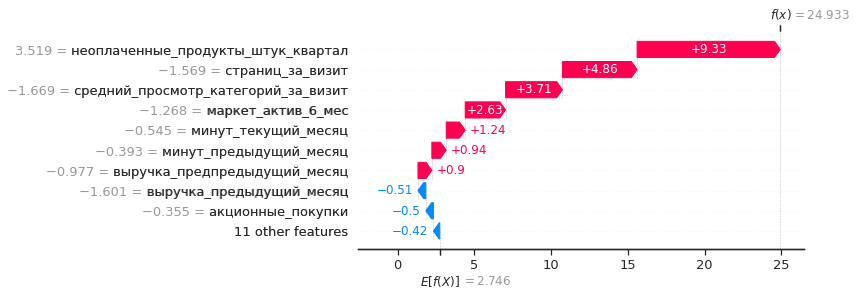

*******************************************************************************************************************************
Index: 46


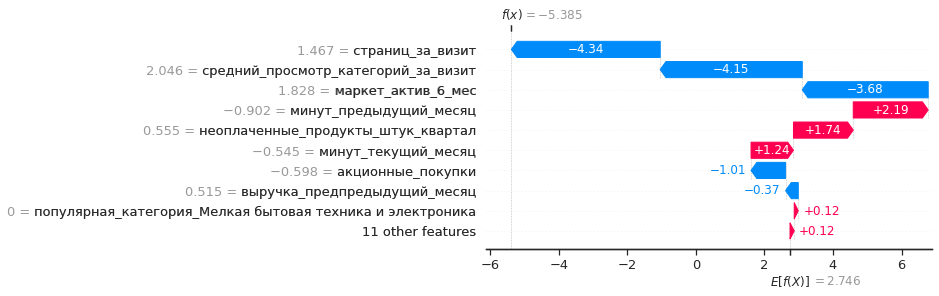

*******************************************************************************************************************************
Index: 50


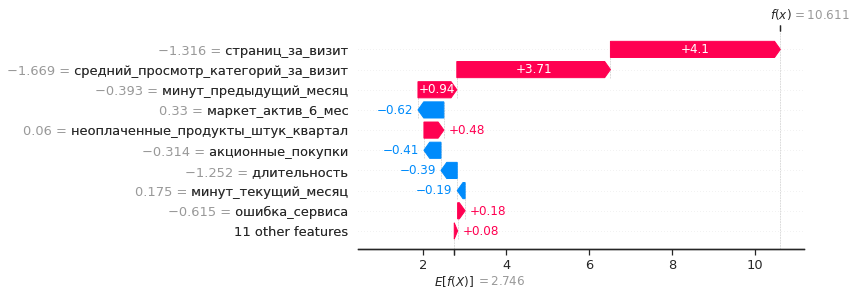

*******************************************************************************************************************************
Index: 53


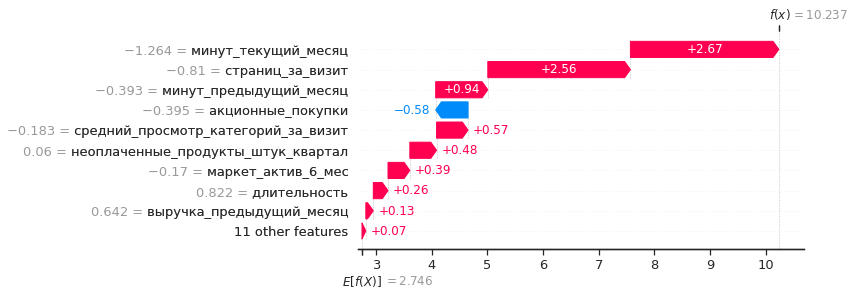

*******************************************************************************************************************************
Index: 74


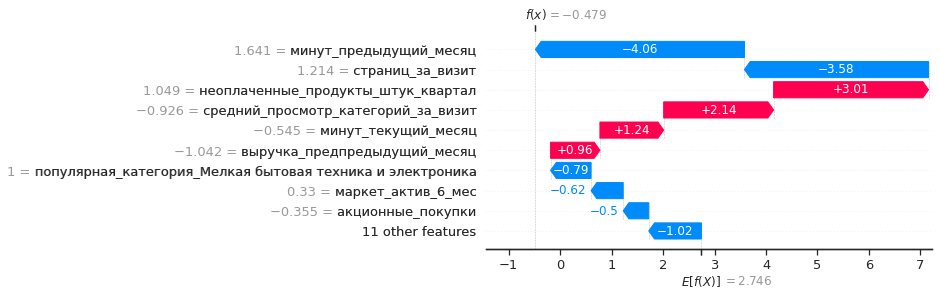

*******************************************************************************************************************************
Index: 79


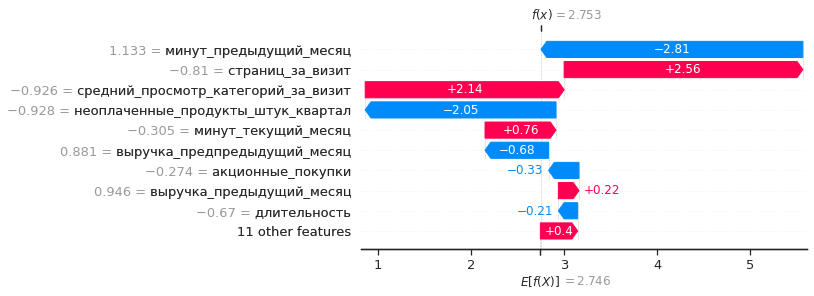

*******************************************************************************************************************************
Index: 82


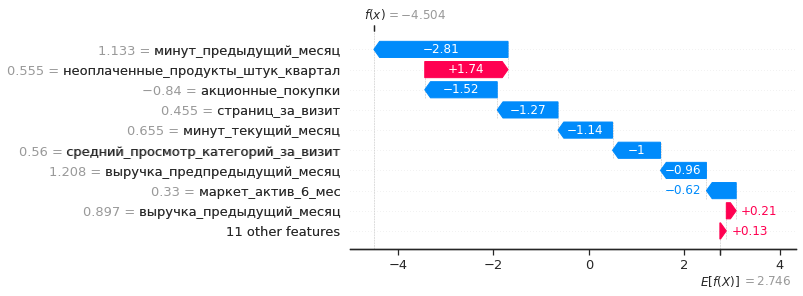

*******************************************************************************************************************************
Index: 89


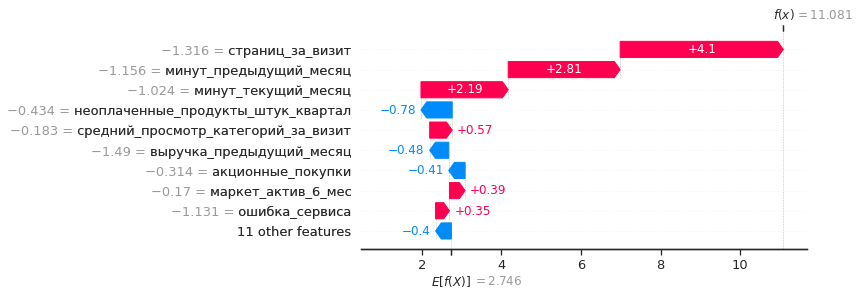

*******************************************************************************************************************************
Index: 90


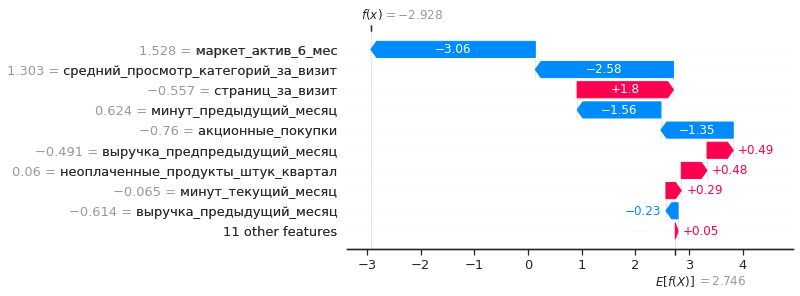

*******************************************************************************************************************************
Index: 91


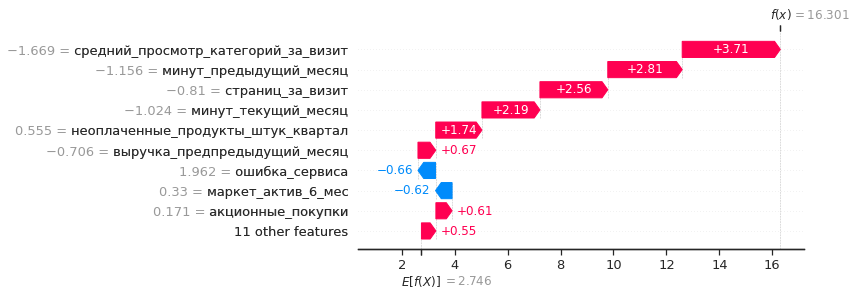

*******************************************************************************************************************************
Index: 95


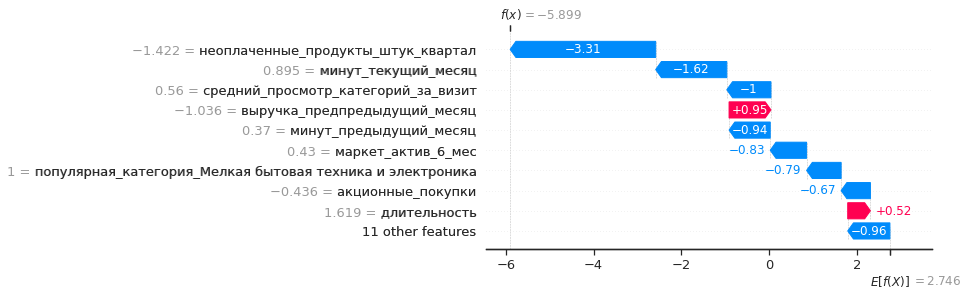

*******************************************************************************************************************************
Index: 96


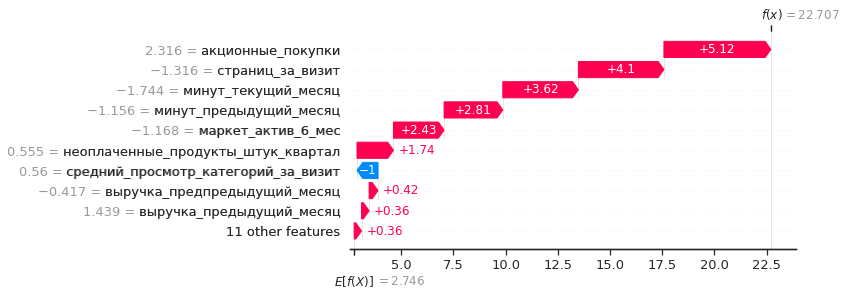

*******************************************************************************************************************************
Index: 105


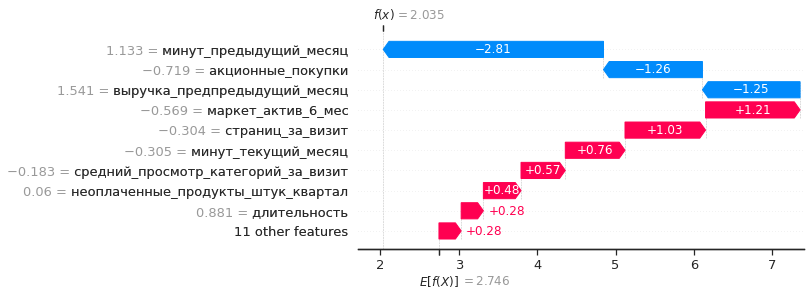

*******************************************************************************************************************************
Index: 106


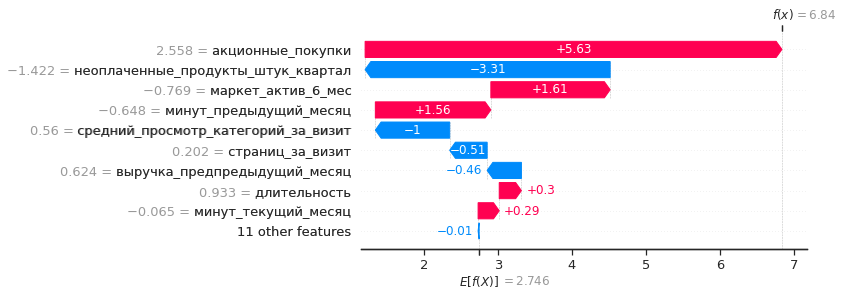

*******************************************************************************************************************************
Index: 115


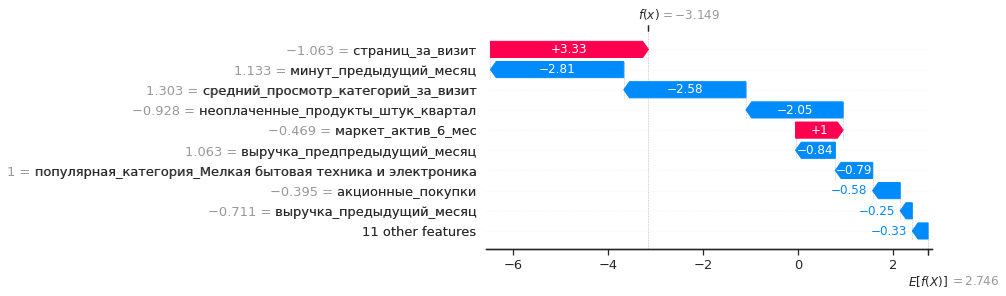

*******************************************************************************************************************************
Index: 116


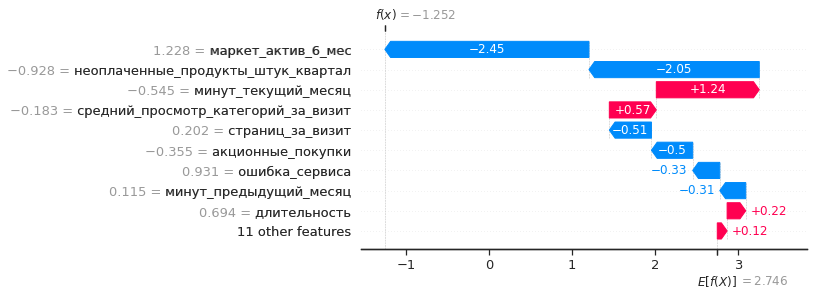

*******************************************************************************************************************************
Index: 117


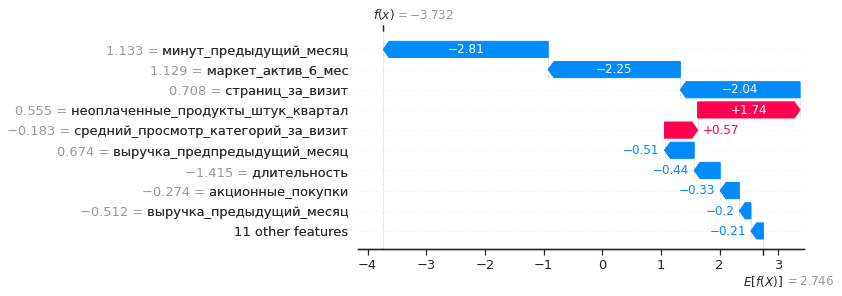

*******************************************************************************************************************************
Index: 126


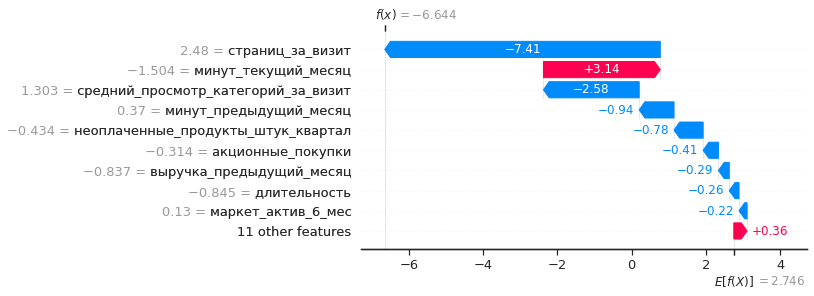

*******************************************************************************************************************************
Index: 132


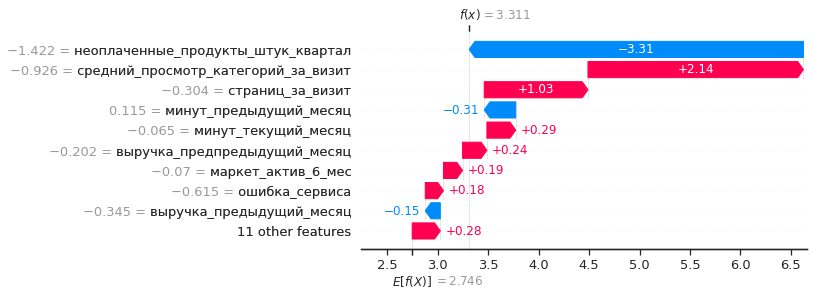

*******************************************************************************************************************************
Index: 134


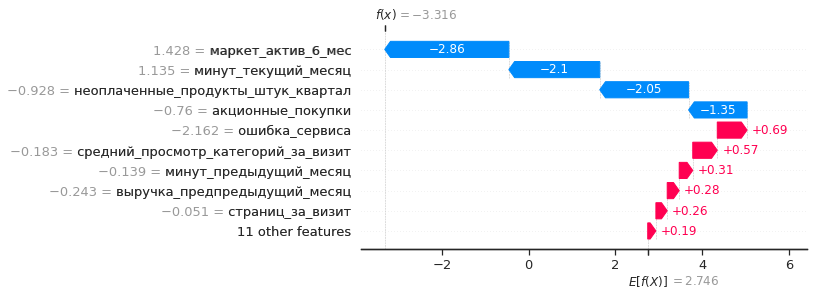

*******************************************************************************************************************************
Index: 139


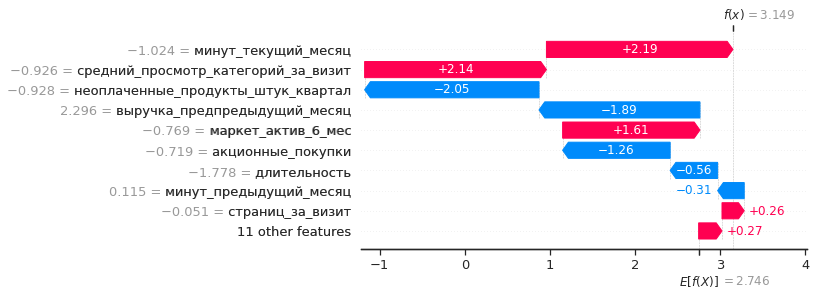

*******************************************************************************************************************************
Index: 140


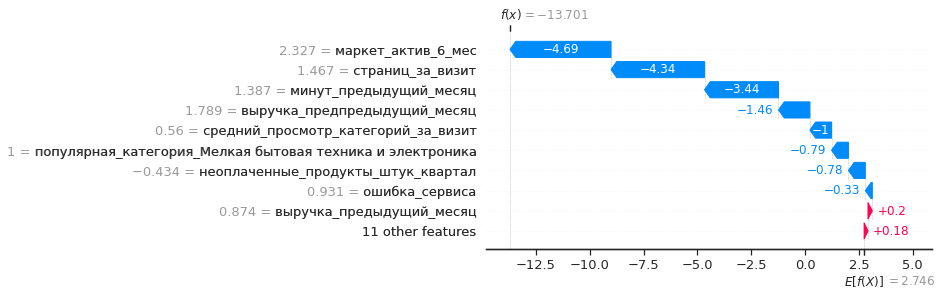

*******************************************************************************************************************************
Index: 142


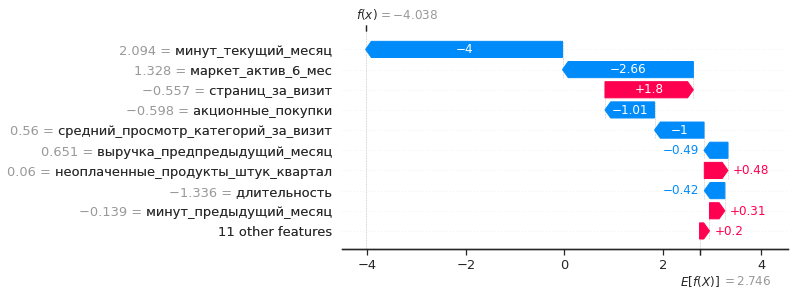

*******************************************************************************************************************************
Index: 147


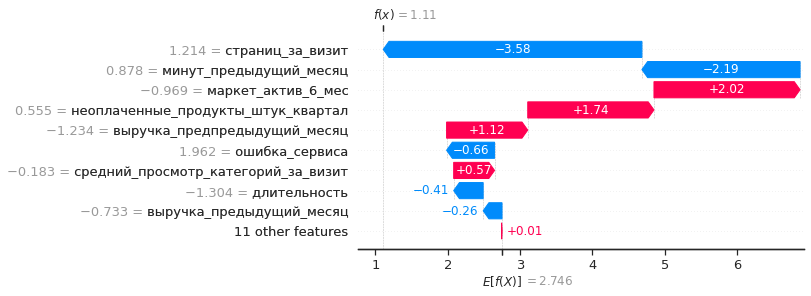

*******************************************************************************************************************************
Index: 149


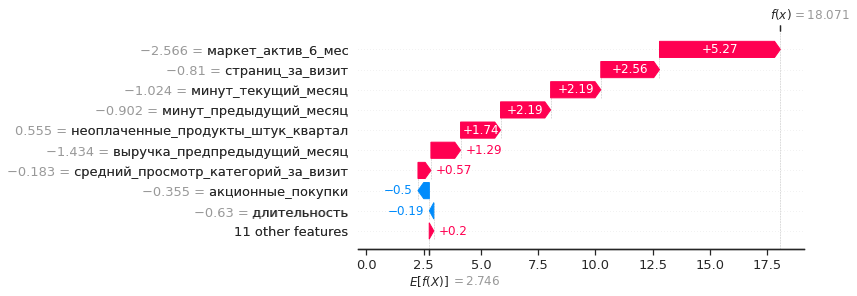

*******************************************************************************************************************************
Index: 153


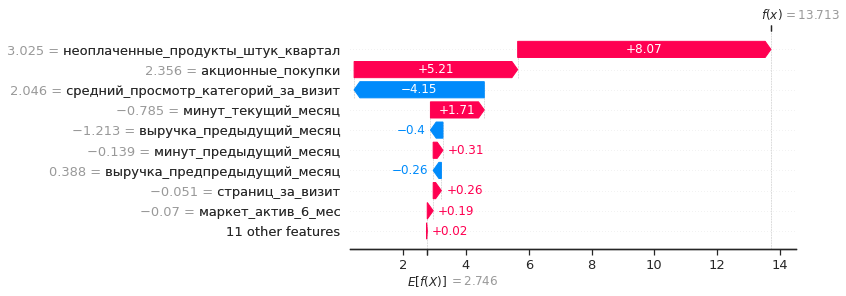

*******************************************************************************************************************************
Index: 168


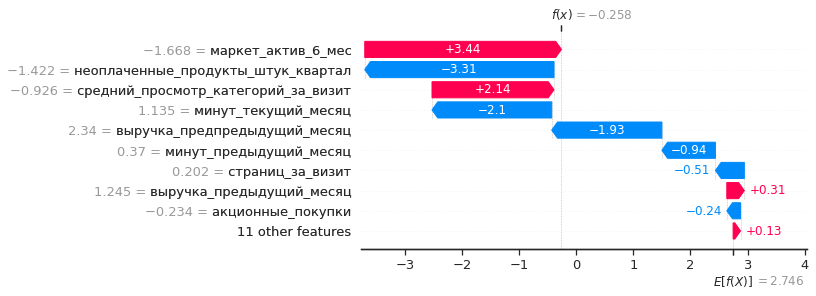

*******************************************************************************************************************************
Index: 169


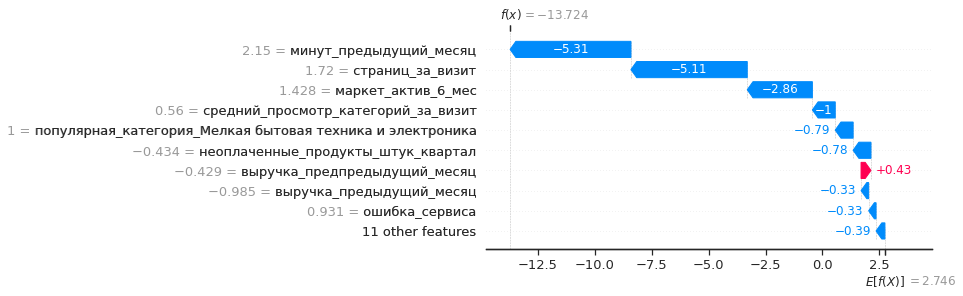

*******************************************************************************************************************************
Index: 172


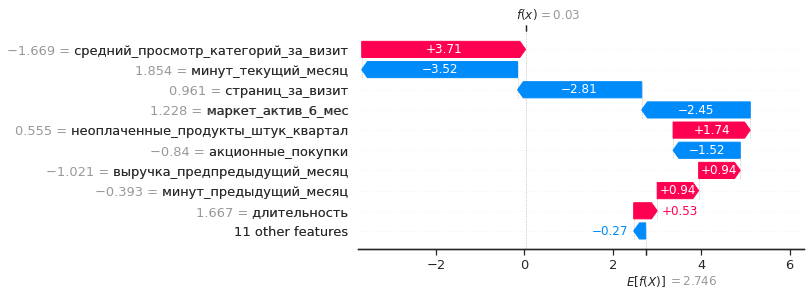

*******************************************************************************************************************************
Index: 173


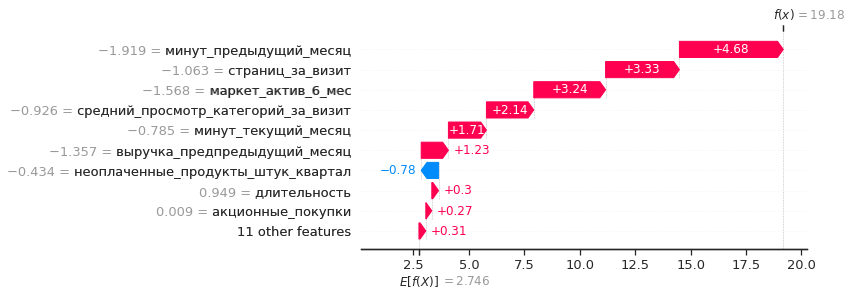

*******************************************************************************************************************************
Index: 177


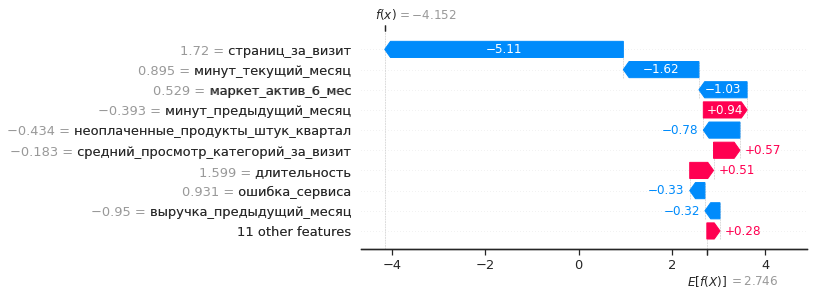

*******************************************************************************************************************************
Index: 185


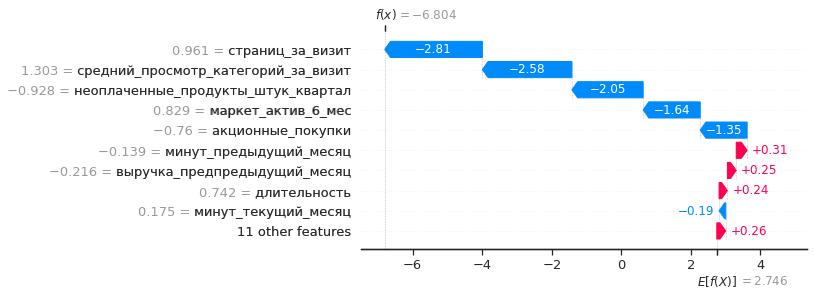

*******************************************************************************************************************************
Index: 186


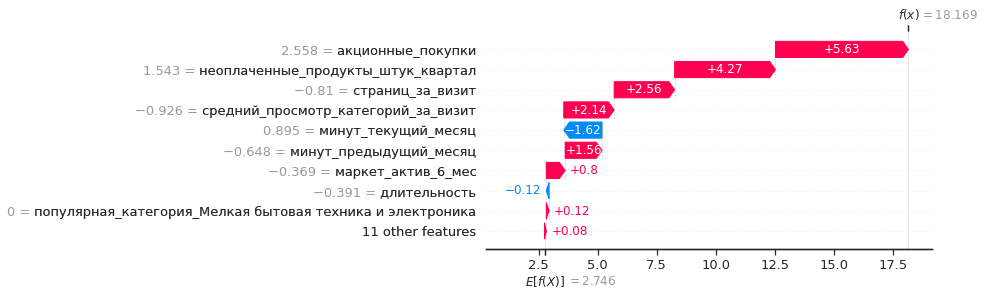

*******************************************************************************************************************************
Index: 191


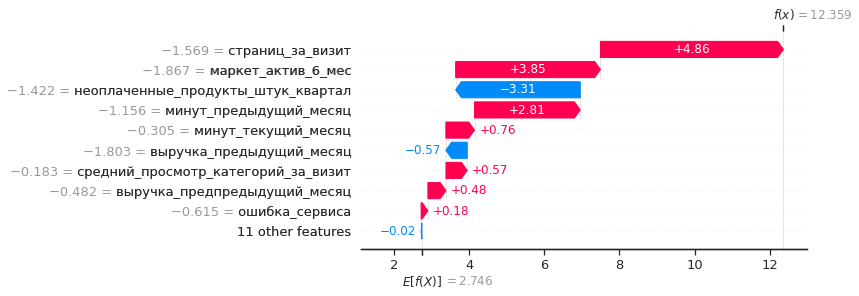

*******************************************************************************************************************************
Index: 194


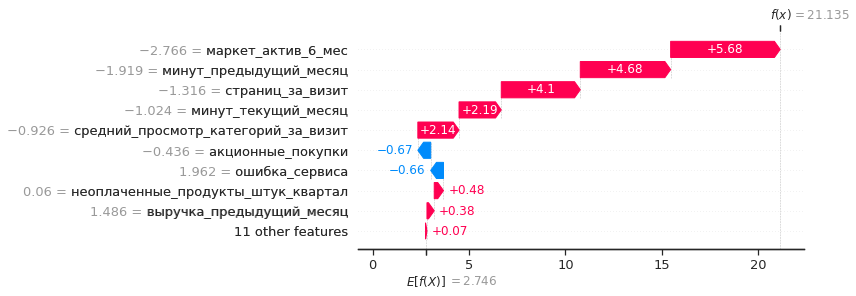

*******************************************************************************************************************************
Index: 202


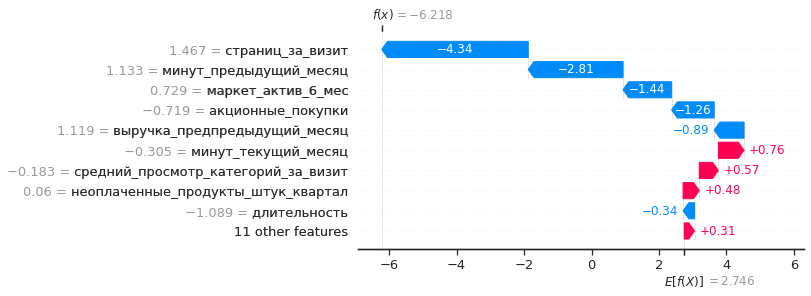

*******************************************************************************************************************************
Index: 215


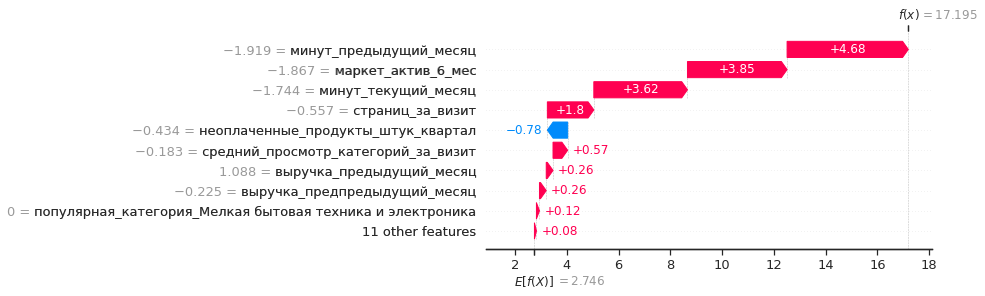

*******************************************************************************************************************************
Index: 216


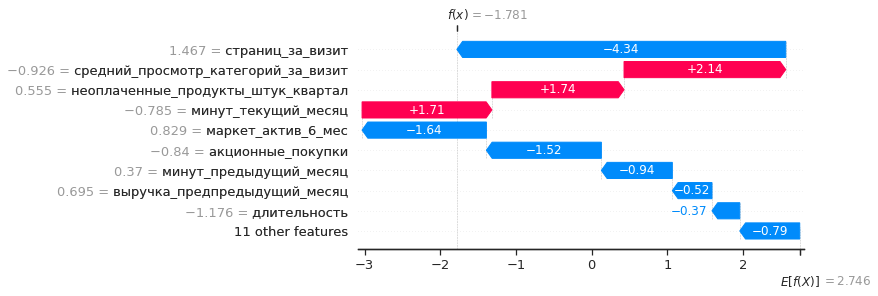

*******************************************************************************************************************************
Index: 220


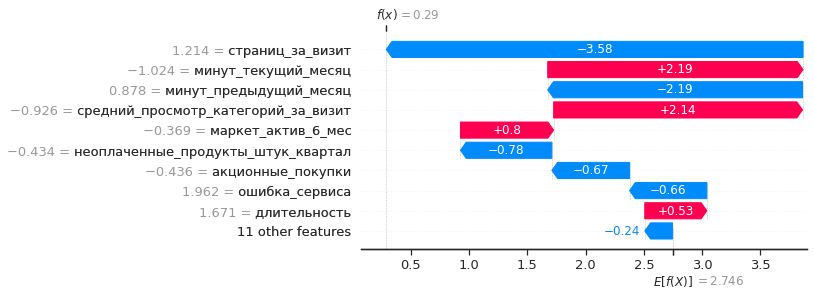

*******************************************************************************************************************************
Index: 227


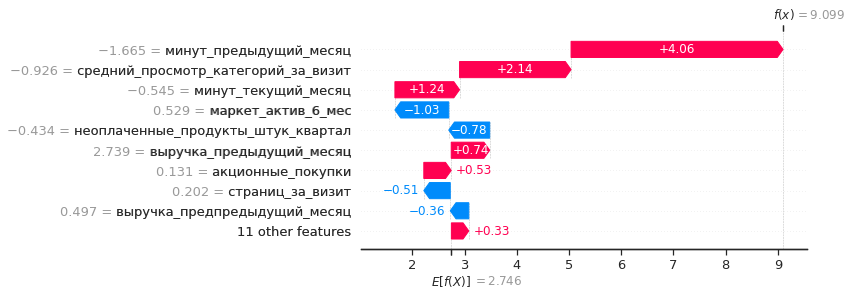

*******************************************************************************************************************************
Index: 239


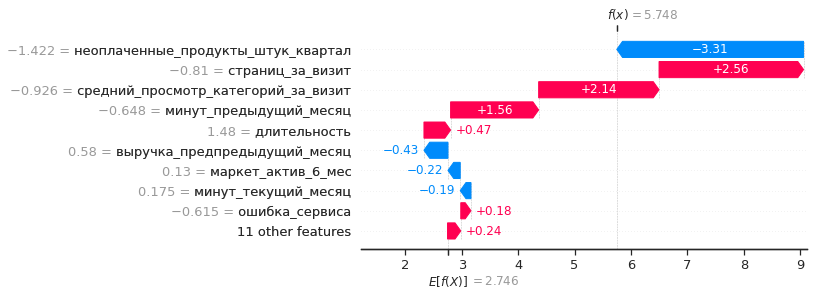

*******************************************************************************************************************************
Index: 242


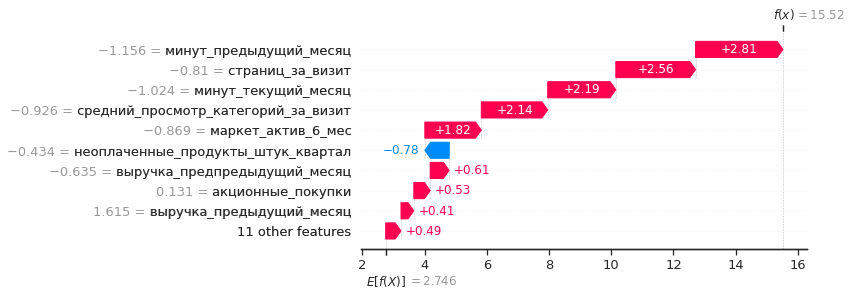

*******************************************************************************************************************************
Index: 246


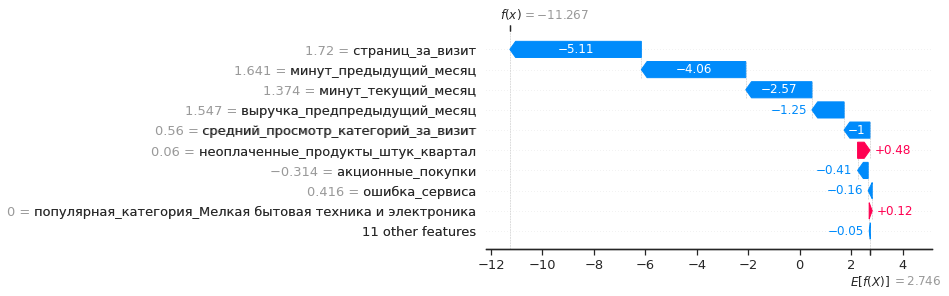

*******************************************************************************************************************************
Index: 247


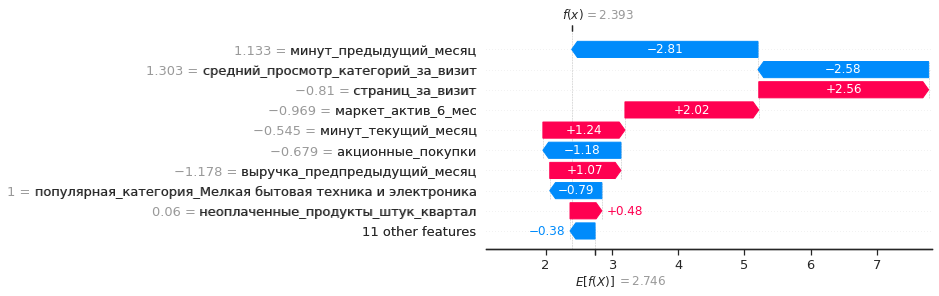

*******************************************************************************************************************************
Index: 258


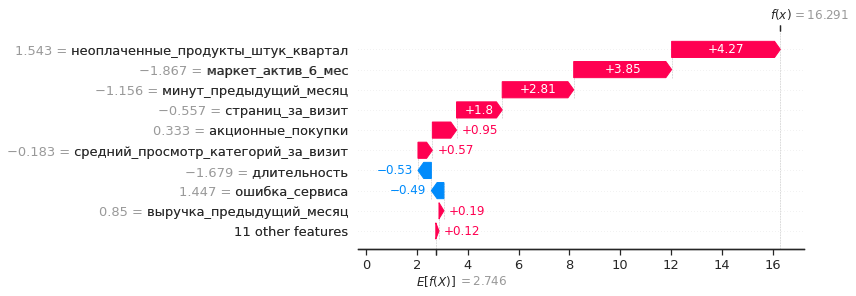

*******************************************************************************************************************************
Index: 261


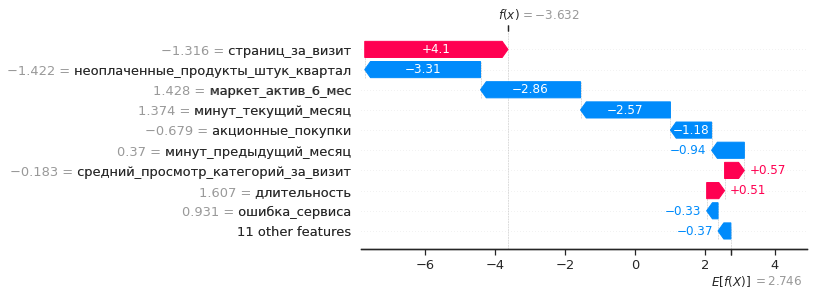

*******************************************************************************************************************************
Index: 266


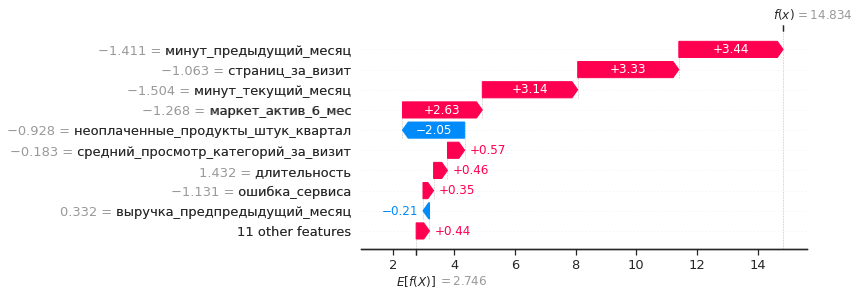

*******************************************************************************************************************************
Index: 267


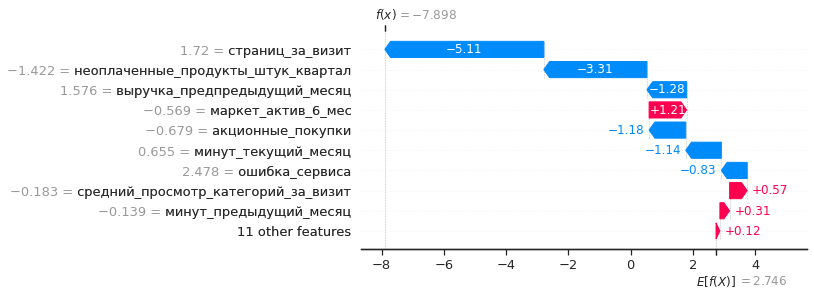

*******************************************************************************************************************************
Index: 268


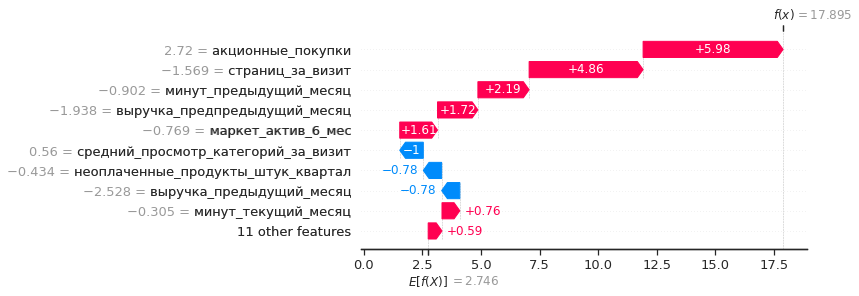

*******************************************************************************************************************************
Index: 273


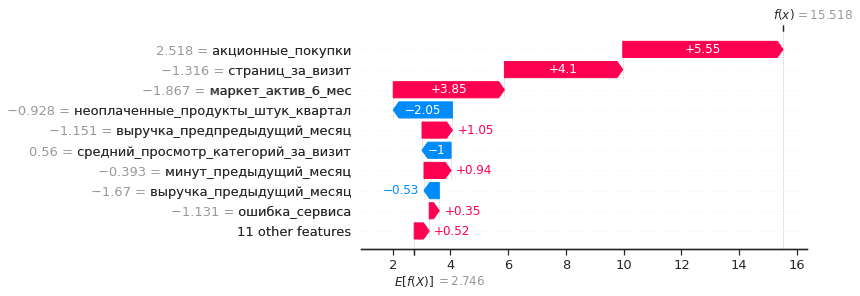

*******************************************************************************************************************************
Index: 274


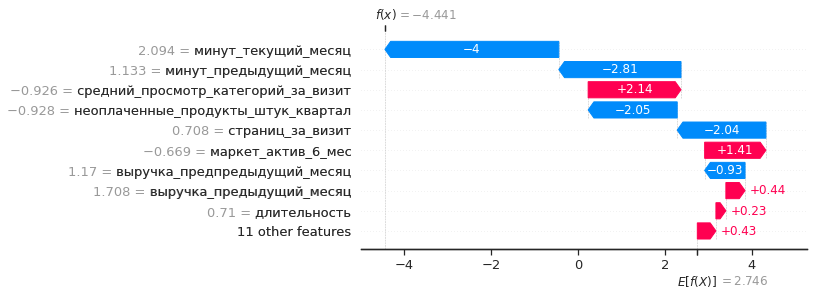

*******************************************************************************************************************************
Index: 277


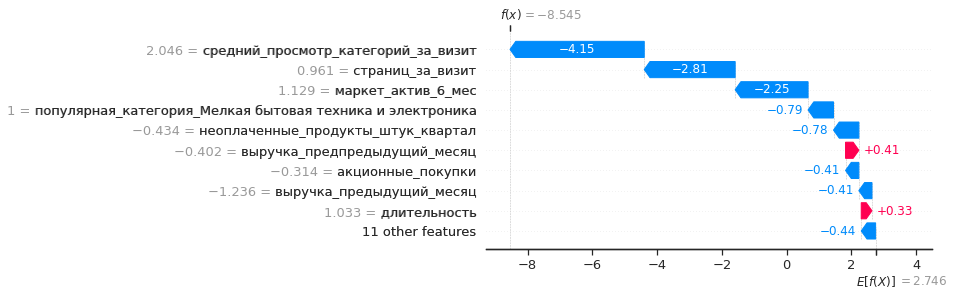

*******************************************************************************************************************************
Index: 282


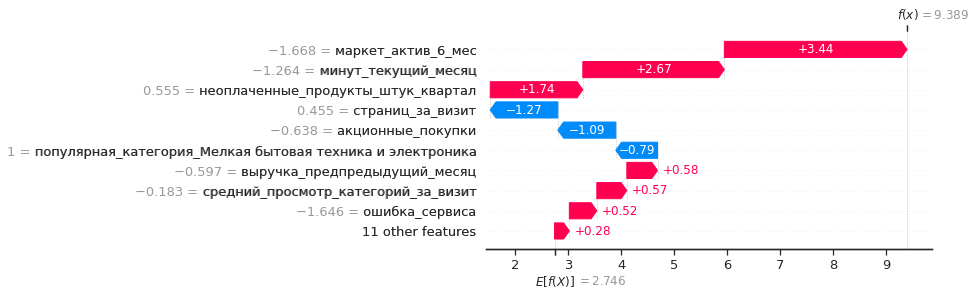

*******************************************************************************************************************************
Index: 285


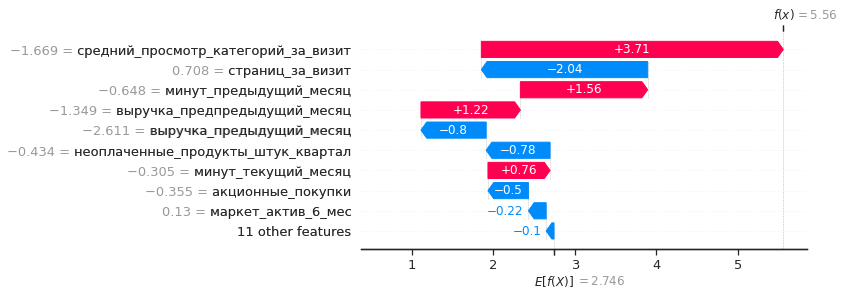

*******************************************************************************************************************************
Index: 294


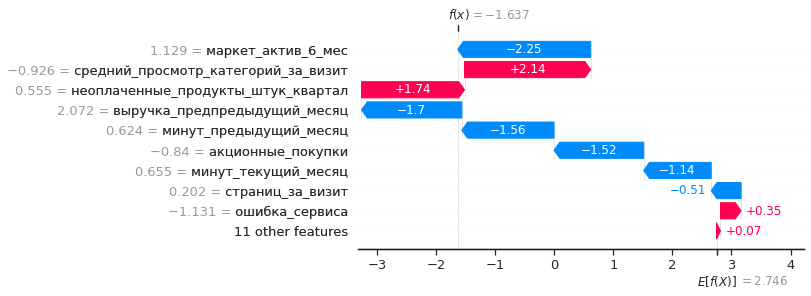

*******************************************************************************************************************************
Index: 299


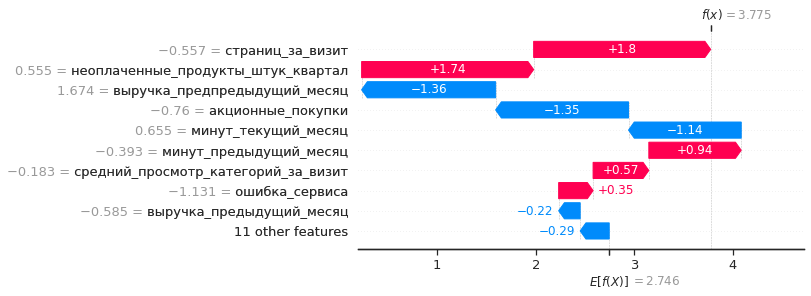

*******************************************************************************************************************************
Index: 300


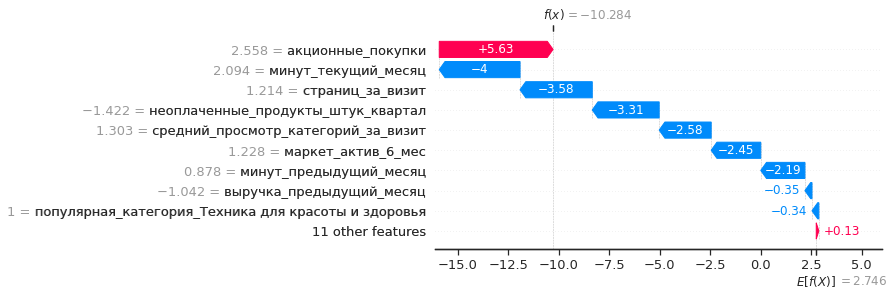

*******************************************************************************************************************************
Index: 306


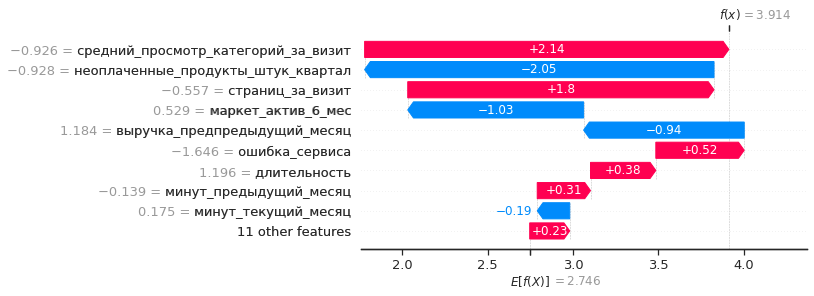

*******************************************************************************************************************************
Index: 308


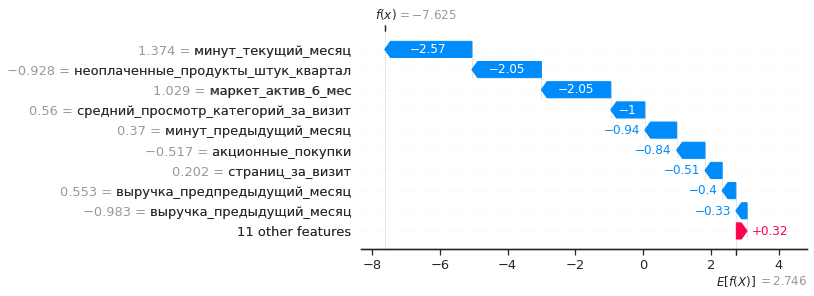

*******************************************************************************************************************************
Index: 310


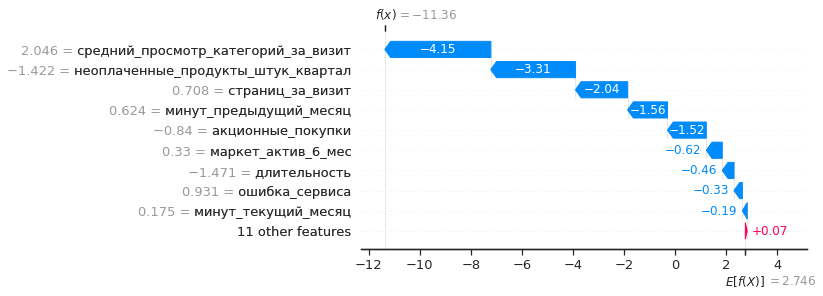

*******************************************************************************************************************************
Index: 312


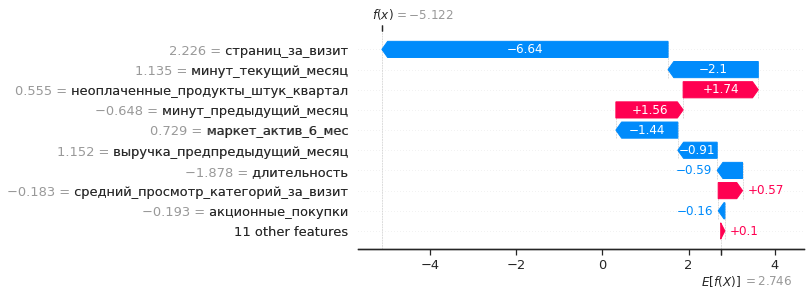

*******************************************************************************************************************************
Index: 322


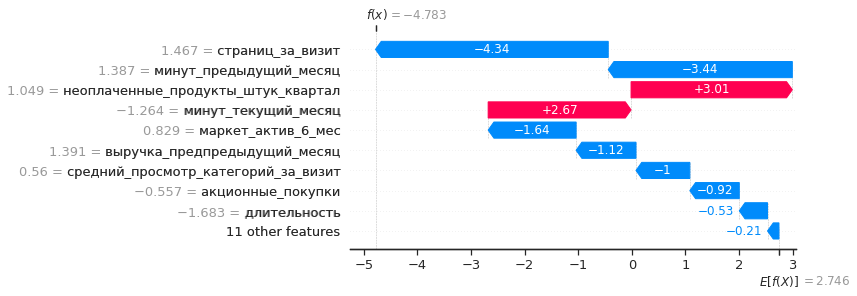

*******************************************************************************************************************************


In [77]:
# в отдельную переменную сохраняем индексы ошибочно присвоенных классов 1
indexes_two = X_test_final.index[(X_test_final['y_test']==0) & (X_test_final['y_pred']==1)].tolist()

# через цикл визуализируем вклады признаков для каждого объекта
for i in indexes_two:
    print('Index:', i)
    fig = plt.figure()
    shap.plots.waterfall(shap_values[i], show=False)
    plt.gcf().set_size_inches(8, 4)
    plt.show()
    print(line_1)

##### Вывод по анализу важности признаков:

Признаки, сильнее всего влияюшие на целевой признак:
- страниц_за_визит
- акционные_покупки
- минут_предыдущий_месяц
- средний_просмотр_категорий_за_визит
- минут_текущий_месяц

## Сегментация покупателей

#### Объединим датафреймы и добавим прогнозы лучшей модели

Сделаем три столбца с тратами покупателей, много,средне,мало, так же сделаем столбец с средним значением.

In [78]:
merged_final['средн_выручка_3_мес'] = (merged_final['выручка_предпредыдущий_месяц']
                                     + merged_final['выручка_предыдущий_месяц']
                                     + merged_final['выручка_текущий_месяц'] ) / 3
merged_final.head(5)

id  покупательская_активность тип_сервиса разрешить_сообщать  \
0  215349                          1     премиум                 да   
1  215350                          1    стандарт                нет   
2  215351                          1    стандарт                 да   
3  215352                          1    стандарт                нет   
4  215353                          1    стандарт                 да   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 4.4                     4           819               0.75   
1                 4.9                     3           539               0.14   
2                 3.2                     5           896               0.99   
3                 5.1                     3          1064               0.94   
4                 3.3                     4           762               0.26   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    4   
1    Домашний текстиль                                    5   
2     Товары для детей                                    5   
3     Товары для детей                                    3   
4    Домашний текстиль                                    4   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
0                                   4               2                 5   
1                                   2               1                 5   
2                                   0               6                 4   
3                                   2               3                 2   
4                                   1               1                 4   

   выручка_текущий_месяц  выручка_предыдущий_месяц  \
0                 4971.6                    5216.0   
1                 5058.4                    5457.5   
2                 6610.4                    6158.0   
3                 5872.5                    5807.5   
4                 5388.5                    4738.5   

   выручка_предпредыдущий_месяц  минут_текущий_месяц  минут_предыдущий_месяц  \
0                        4472.0                   10                      12   
1                        4826.0                   13                       8   
2                        4793.0                   13                      11   
3                        4594.0                   11                       8   
4                        5124.0                   10                      10   

   средн_выручка_3_мес  
0          4886.533333  
1          5113.966667  
2          5853.800000  
3          5424.666667  
4          5083.666667

In [79]:
merged_final['группировка_по_выручке'] = pd.qcut(merged_final['средн_выручка_3_мес'],
                                                 q=3, 
                                                 labels=['мало', 'среднее', 'много']
                                                )
                                        
merged_final.head(5)

id  покупательская_активность тип_сервиса разрешить_сообщать  \
0  215349                          1     премиум                 да   
1  215350                          1    стандарт                нет   
2  215351                          1    стандарт                 да   
3  215352                          1    стандарт                нет   
4  215353                          1    стандарт                 да   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 4.4                     4           819               0.75   
1                 4.9                     3           539               0.14   
2                 3.2                     5           896               0.99   
3                 5.1                     3          1064               0.94   
4                 3.3                     4           762               0.26   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    4   
1    Домашний текстиль                                    5   
2     Товары для детей                                    5   
3     Товары для детей                                    3   
4    Домашний текстиль                                    4   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
0                                   4               2                 5   
1                                   2               1                 5   
2                                   0               6                 4   
3                                   2               3                 2   
4                                   1               1                 4   

   выручка_текущий_месяц  выручка_предыдущий_месяц  \
0                 4971.6                    5216.0   
1                 5058.4                    5457.5   
2                 6610.4                    6158.0   
3                 5872.5                    5807.5   
4                 5388.5                    4738.5   

   выручка_предпредыдущий_месяц  минут_текущий_месяц  минут_предыдущий_месяц  \
0                        4472.0                   10                      12   
1                        4826.0                   13                       8   
2                        4793.0                   13                      11   
3                        4594.0                   11                       8   
4                        5124.0                   10                      10   

   средн_выручка_3_мес группировка_по_выручке  
0          4886.533333                среднее  
1          5113.966667                среднее  
2          5853.800000                  много  
3          5424.666667                  много  
4          5083.666667                среднее

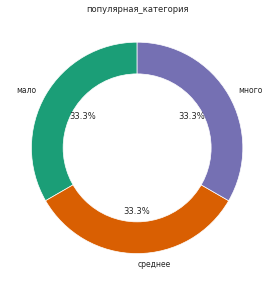

группировка_по_выручке
мало       432
среднее    432
много      432
Name: id, dtype: int64

In [80]:
segment_data = merged_final.pivot_table(index = 'группировка_по_выручке', values = 'id', aggfunc = 'count')
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi= 50)
plt.pie(segment_data['id'], labels = segment_data.index, autopct = '%1.1f%%', startangle = 90, colors=plt.cm.Dark2.colors)
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title(col)
plt.show()
segment_data['id']

Видно что группы распределенны равномерно.

In [81]:
display(merged_final['средн_выручка_3_мес'].describe())

count    1296.000000
mean     5007.255658
std       527.112378
min      3479.200000
25%      4651.441667
50%      5024.183333
75%      5362.341667
max      6588.833333
Name: средн_выручка_3_мес, dtype: float64

Проанализировав данные можно сказать что аномальных значений у нас нет.  
Посмотрим на пользователей которые тратят много по акциям.

In [82]:
data_segment = merged_final[merged_final['группировка_по_выручке'] == 'много'].sort_values(
    by = 'средн_выручка_3_мес', ascending = False)
data_segment['доля_покупок_по_акции'] = data_segment.apply(
    lambda row: 'да' if row['акционные_покупки'] > 0.7 else 'нет', axis = 1)
print(f'Доля любителей акционных покупок = {data_segment["доля_покупок_по_акции"].value_counts().min() / (data_segment["доля_покупок_по_акции"].value_counts().sum())}')
data_segment['доля_покупок_по_акции'].value_counts()

Доля любителей акционных покупок = 0.12268518518518519


нет    379
да      53
Name: доля_покупок_по_акции, dtype: int64

In [83]:
data_segment['покупательская_активность'] = data_segment['покупательская_активность'].replace(
    [0, 1], ['останется_прежней', 'снизится'])

In [84]:
display(data_segment.head(5))

id покупательская_активность тип_сервиса разрешить_сообщать  \
489  215841                  снизится    стандарт                 да   
83   215435                  снизится     премиум                 да   
141  215493                  снизится    стандарт                 да   
792  216144         останется_прежней    стандарт                 да   
206  215558                  снизится    стандарт                 да   

     маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
489                 6.3                     4           320   
83                  4.8                     4           875   
141                 4.0                     5           881   
792                 4.8                     4           541   
206                 4.6                     5           867   

     акционные_покупки                  популярная_категория  \
489               0.12  Мелкая бытовая техника и электроника   
83                0.35                      Товары для детей   
141               0.99                       Кухонная посуда   
792               0.29  Мелкая бытовая техника и электроника   
206               0.25                       Кухонная посуда   

     средний_просмотр_категорий_за_визит  неоплаченные_продукты_штук_квартал  \
489                                    5                                   4   
83                                     2                                   2   
141                                    3                                   5   
792                                    3                                   5   
206                                    2                                   6   

     ошибка_сервиса  страниц_за_визит  выручка_текущий_месяц  \
489               4                10                 7557.0   
83                5                 9                 7605.3   
141               6                 5                 7799.4   
792               5                 9                 7547.8   
206               3                 5                 7212.3   

     выручка_предыдущий_месяц  выручка_предпредыдущий_месяц  \
489                    6588.5                        5621.0   
83                     6869.5                        5008.0   
141                    6716.5                        4870.0   
792                    6337.5                        5091.0   
206                    6658.5                        4968.0   

     минут_текущий_месяц  минут_предыдущий_месяц  средн_выручка_3_мес  \
489                   12                       9          6588.833333   
83                    11                       7          6494.266667   
141                   10                       9          6461.966667   
792                   11                      19          6325.433333   
206                   14                      12          6279.600000   

    группировка_по_выручке доля_покупок_по_акции  
489                  много                   нет  
83                   много                   нет  
141                  много                    да  
792                  много                   нет  
206                  много                   нет

In [85]:
low=data_segment[data_segment['доля_покупок_по_акции'] == 'да']['средн_выручка_3_мес'].describe()
low

count      53.000000
mean     5599.222642
std       245.618554
min      5265.766667
25%      5407.433333
50%      5544.200000
75%      5737.500000
max      6461.966667
Name: средн_выручка_3_мес, dtype: float64

In [86]:
data_segment[data_segment['доля_покупок_по_акции'] == 'нет']['средн_выручка_3_мес'].describe()

count     379.000000
mean     5576.432982
std       261.875599
min      5248.866667
25%      5359.866667
50%      5515.400000
75%      5723.700000
max      6588.833333
Name: средн_выручка_3_мес, dtype: float64

In [87]:
data_segment

id покупательская_активность тип_сервиса разрешить_сообщать  \
489  215841                  снизится    стандарт                 да   
83   215435                  снизится     премиум                 да   
141  215493                  снизится    стандарт                 да   
792  216144         останется_прежней    стандарт                 да   
206  215558                  снизится    стандарт                 да   
..      ...                       ...         ...                ...   
841  216193         останется_прежней    стандарт                 да   
682  216034         останется_прежней    стандарт                 да   
694  216046         останется_прежней     премиум                 да   
29   215381                  снизится    стандарт                 да   
717  216069         останется_прежней    стандарт                 да   

     маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
489                 6.3                     4           320   
83                  4.8                     4           875   
141                 4.0                     5           881   
792                 4.8                     4           541   
206                 4.6                     5           867   
..                  ...                   ...           ...   
841                 3.2                     4           191   
682                 3.9                     4           735   
694                 5.5                     4           170   
29                  3.6                     5           554   
717                 5.5                     4          1052   

     акционные_покупки                  популярная_категория  \
489               0.12  Мелкая бытовая техника и электроника   
83                0.35                      Товары для детей   
141               0.99                       Кухонная посуда   
792               0.29  Мелкая бытовая техника и электроника   
206               0.25                       Кухонная посуда   
..                 ...                                   ...   
841               0.19                      Товары для детей   
682               0.17  Мелкая бытовая техника и электроника   
694               0.28                     Домашний текстиль   
29                0.33                     Домашний текстиль   
717               0.24                     Домашний текстиль   

     средний_просмотр_категорий_за_визит  неоплаченные_продукты_штук_квартал  \
489                                    5                                   4   
83                                     2                                   2   
141                                    3                                   5   
792                                    3                                   5   
206                                    2                                   6   
..                                   ...                                 ...   
841                                    4                                   4   
682                                    3                                   0   
694                                    4                                   5   
29                                     6                                   1   
717                                    2                                   3   

     ошибка_сервиса  страниц_за_визит  выручка_текущий_месяц  \
489               4                10                 7557.0   
83                5                 9                 7605.3   
141               6                 5                 7799.4   
792               5                 9                 7547.8   
206               3                 5                 7212.3   
..              ...               ...                    ...   
841               5                13                 5258.0   
682               8                 8                 5514.4   
694               3                11                 5689.6   
29               

Можно сказать что пользователи активно участвующие в акции и те кто не очень активен в среднем тратят почти одинаково.

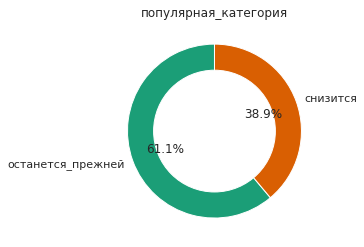

покупательская_активность
останется_прежней    264
снизится             168
Name: id, dtype: int64

In [88]:
data_action_on_sale = data_segment.pivot_table(index = 'покупательская_активность',
                                               values = 'id',
                                               aggfunc = 'count'
                                              )
plt.pie(data_action_on_sale['id'],
        labels = data_action_on_sale.index,
        autopct = '%1.1f%%', startangle = 90,
        colors=plt.cm.Dark2.colors
       )
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title(col)
plt.title(col)
plt.show()
data_action_on_sale['id']

Наблюдаем что 61% пользователей сохранят прежний уровень покупательской активности.

Доля пользователи с количеством акциионных покупок выше 70%: 53
*******************************************************************************************************************************
Хотят ли они получать уведомления об акциях:
да     37
нет    16
Name: разрешить_сообщать, dtype: int64
*******************************************************************************************************************************
Наиболее популярные категории пользователей с количеством акциионных покупок выше 70%:
Косметика и аксесуары                   13
Домашний текстиль                       11
Кухонная посуда                         10
Товары для детей                         9
Мелкая бытовая техника и электроника     7
Техника для красоты и здоровья           3
Name: популярная_категория, dtype: int64
*******************************************************************************************************************************
Подписка пользователей с долей акционных покупок выше 70%:
ста

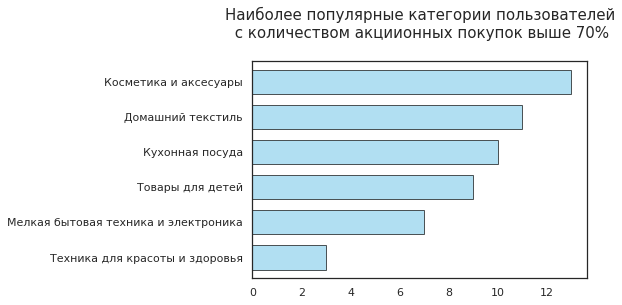

*******************************************************************************************************************************


In [89]:
# изучим покупателей, склонных совершать в основном акционные покупки
print('Доля пользователи с количеством акциионных покупок выше 70%:', 
      data_segment[data_segment['акционные_покупки'] > 0.7]['id'].count())
print(line_1)

print('Хотят ли они получать уведомления об акциях:')
print(data_segment[data_segment['акционные_покупки'] > 0.7]['разрешить_сообщать'].value_counts())
print(line_1)

print('Наиболее популярные категории пользователей с количеством акциионных покупок выше 70%:')
print(data_segment[data_segment['акционные_покупки'] > 0.7]['популярная_категория'].value_counts())
print(line_1)
print('Подписка пользователей с долей акционных покупок выше 70%:')
print(data_segment[data_segment['акционные_покупки'] > 0.7]['тип_сервиса'].value_counts())

print(line_1)


(data_segment[data_segment['акционные_покупки'] > 0.7]['популярная_категория']
 .value_counts(ascending=True)
 .plot(kind='barh', color='skyblue', ec='black', lw=1, alpha=0.65, width=0.7))
plt.title('Наиболее популярные категории пользователей\n с количеством акциионных покупок выше 70%\n', size=15)
plt.show()
print(line_1)

#### Вывод по сегментации покупателей:

- Объединили датафреймы, добавили прогнозы и данные о прибыльности
- Выбрали сегмент для анализа:    
и высокой вероятностью снижения покупательской активности (>0.7)
- Изучили распределение прибыльности в выбранном сегменте
- Сравнили прибыльность выбранного сегмента (высокая вероятность снижения покупательской активности) с прибыльностью покупателей с низкой вероятностью снижения покупательской активности
- Изучили внутри выбранного сегмента:  
отношение к рассылкам  
популярные категори покупок  
типы сервиса  
- Более детально изучили покупателей с высокой (>0.8) долей акционных покупок

Исследовали группы пользователей разделенных по показателю средней выручки за 3 месяца, можно подчеркнуть следующие моменты:

- наблюдается ~61% пользователей, покупательская активность осталась на прежнем уровне
- любители совершать покупки по акциям приносят в среднем такую же прибыль, сколько в среднем приносит пользователь, не участвующий в акции

Предложения по увеличению покупательской активности для выбранного сегмента:

Имеем 53 покупателей с высокой прибыльностью.
Из них 35 покупателей (почти 70%) сегмента лояльно относятся к информационным и рекламным рассылкам.
- Для её увеличения либо поддержания на прежнем уровне можно предложить:
 - 53 покупателей имеют высокую (>70%) ежемесячную долю акционных покупок. То есть спрос этих покупателей эластичен по отношению к цене товара. Более того, 37 из них дали согласие на получение рекламных сообщений.
   - Можно предложить данным пользователям промокоды на скидки на товары тех категорий, которые они предпочитают, исходя из данных за прошлые месяцы.  
Косметика и аксессуары - 13 покупателя  
Домашний текстиль - 11 покупателя  
Кухонная посуда - 10 покупателя  
Товары для детей - 9 покупателя  
Мелкая бытовая техника и электроника - 7 покупателя  
Техника для красоты и здоровья - 3 покупатель  


- Возможно стоит попробовать затянуть их глубже в сайт, сделать так, чтобы они просматривали больше страниц. Больше страниц - больше контактов с сайтом, а значит и больше вероятность совершения покупки.
- Стоит рассмотреть возможность создания всплывающих окон с предложениями для покупки, исходя из персональных предпочтений.
  
 
Я бы порекомендовал магазину проводить побольше различных акций, побуждающих пользователей в них участвовать. Подобно некоторым маркетплейсам можно установить календарь, где конец одной акции сменяется началом другой. 

## Общий вывод

В ходе работы над проектом были проанализированны данные интренет-магазина "в один клик". Наличие на просторах интернета таких гигантов маркетплейса как "Ozon" и "Wildberries" затрудняет приток новых клиентов, поэтому "в один клик" хочет удержать своих постоянных клиентов и поддерживать их активность персональными предложениями.

#### Вывод по предобработке данных

- во всех датафреймах отсутствую пропущенные значения,
- дубликаты отсутствуют, но есть неявные дубликаты - избавились от них,
- названия колонок были частично в змеином формате - обработали все названия колонок, привели к змеиному формату и нижнему регистру.

Анализируя категориальные признаки можно сказать следующее:

- прежний уровень покупательской активности поддерживает большинство, 802 пользователя,
пользователей с стандартной подпиской больше в 2.46 раза, чем с премиум подпиской,
- в основном покупатели дают согласие на то, что бы им сообщали о дополнительные предложения о товаре этот выбор делают 962 пользователя из 1300.
- самая популярная категория - товары для детей ее выбирают 330 пользователей из 1300, а из всего списка самая менее популярная - кухонная посуда, ей предпочения отдают 138 пользователй.

Рассмотрев корреляционную матрицу числовых значений можно сказать что, зависимости между ними очень слабая.  

Анализируя количественные признаки можно сказать следующее:
- ни один из количественных признаков не является нормальным / гауссовым,
- количество маркетинговых коммуникаций в текущем месяце распределенно очень сжато первый, второй и третий квартили совпадают,
- длительность распределена более менее равномерно среди всех пользователей, но, безусловно, имеются и отдельные случаи(например самые давние пользователи). Медиана -606, макс - 1079, мин - 110,
- распределение доли среднемесячных акционных покупок за 6 месяцев имеет два локальных максимума, в районе 0.3 и ближе к 1.0, Медиана - 0.24, макс - 0.99, мин - 0,
- распределение среднего количества просмотров категорий за визит показывает что в среднем люди смотрят на 3 категории за визит, и максимум 6, вряд ли человек целенаправленно решил рассматривать именно 6 категорий перед посещением сайта, могу предположить что на таких клиентов хорошо работают рекомендации, чего нельзя сказать о пользователях с 1 просмотренной категорией - эти люди пришли за чем то конкретным, остальное их в данный момент не интерисовало.
- общее число неоплаченных товаров в корзине за последние 3 месяца показывает что в основном у пользователей 3 неоплаченых товара, и максимум - 10,
- число сбоев, которые коснулись покупателя во время посещения сайта, было бы не плохо вести статистику ошибок, данные в таком формате малоинформативны, мы просто видим наличие ошибки, а что именно привело к ней? определенная процедура клиента? или же сбои сайта и ошибки были в одно время у всех пользователей, нужно будет попросить заказчика ввести описание ошибок (или передать нам эти описания если они есть), для выявления и устранения коренной причины появления ошибок. ну а по тем данным что есть можно сказать что в среднем у пользователей 4 ошибки, максимум 9,
- среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца. в среднем пользователи смотрят по 8 страниц, а максимум 20.  
- Из наблюдений видно что, у людей с 8ми и более неоплаченными товарами в корзине в 33 из 34 случаев покупательская активность снизилась.  
- Среднее значение времени провождения на сайте = 13 минутам, мин значением = 4 минутам и макс значением = 23 минуты.
- "Прибыль" имеет нормальное распределение, с средним значением - 3.99, минимальным - 0.86, максимальным - 7.43
- Количество пользователей с постоянной покупательской активностью в течение последних трёх месяцев: 1297.  

Выбросы: 
- акционные_покупки: наблюдаются весьма высокие показатели, скорее всего это либо любители закупаться на акциях, либо пользователи, которые случайно забрели в акции(например при оформлении первой своей покупки), впрочем не столь это важно, такие наблюдения вполне объяснимы
- неоплаченные_продукты_штук_квартал: повышенные значения тоже вполне объяснимы, существуют люди, которые набирают себе корзину, затем либо забывают о товаре, либо вовсе передумывают покупать, возможно у магазина на сайте нет категории избранное, что вряд ли, скорее всего при таком раскладе медианное значение было бы значительно выше
-  Аномальное значение зафиксировано в текущем месяце столбца 'выручка', в предыдущие два месяца выручка составляет 5051 и 6077. То есть, для данного покупателя такое потребительское поведение явно не свойственно.

#### Для поиска лучшей модели:

- был проведён корреляционный анализ всех признаков с целевым
- был подготовлен объединённый датафрейм для моделирования
- данные были разделены на выборки с учётом стратифакации, так как был обнаружен дисбаланс классов
- для выбора лучшей комбинации модели и гиперпараметров был создан пайплайн, в который вошли модели:  
  - DecisionTreeClassifier() с гиперпараметрами: max_depth от 2 до 4 включительно, max_features от 2 до 4 включительно. 
  - KNeighborsClassifier() с гиперпараметром: n_neighbors от 2 до 4 включительно. 
  - LogisticRegression() - с решателем solver='liblinear' и лассо-регуляризацией с гиперпараметром,С от 1 до 4 включительно. 
  - SVC() - с линейным ядром kernel='linear' с гиперпараметром, перебор «силы» модели для ядра от 1 до 9 включительно.
- Эффективность выбранной модели оценивали метрикой ROC-AUC на тренировочной и тестовой выборках. Данная метрика лучше всего подходит для задачи бинарной классификации с несбалансированным целевым признаком.  

В результате была выбрана лучшая модель:
- LogisticRegression, с скайлером - MinMaxScaler(), с «силой» 1. 
- Метрика ROC-AUC на тестовой выборке: 0.91

#### Выбранный сегмент для анализа:  
- покупатели с высокой прибыльностью
- и высокой вероятностью снижения покупательской активности (>0.7) 


- Предложения:
  - Рассмотреть возможность создания всплывающих окон с предложениями для покупки, исходя из персональных предпочтений
  - Премиальным пользователям предложить скидку "постоянного клиента" на премиум обслуживание на три месяца
  - Пользователям со стандартным обслуживанием сделать выгодное предложение на переход на премиум-обслуживание
  - Внутри сегмента предложить покупателям категорий Косметика и аксессуары и Товары для детей скидки на данные категории
  - Чаще предлагать эти категории данным пользователям во время их визита на сайт


<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>



Даже не знаю как оценивать твою работу, так как вижу целыми блоками уже увиденный код, поэтому предлагаю тебе старательно и самостоятельно поработать на второй итерации 

 
    
Обязательное к исправлению:



  
    
    
    
    

- неверно подсчитана roc-auc 

    
    
    
- в тренажере была неточность, .best_score_ это метрика по кросс валидации

    
    

- попробуй вытащить модель и данные из pipeline, а не обучать её заново    
    
   
    
- логистическая регрессия есть ещё логарифм, поэтому для корректной оценки данных нужно ещё взяь экспоненту    

    
    
    
- трудно оценивать раздел сегментации если он слова в слово с работы которую я уже видел    


Жду исправлений, для принятия проекта. Если какие то вопросы, то сразу спрашивай ) 



<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюераV2</b></font>

Спасибо за работу!    

    


Что осталось из красного:

 
- пояснил по поводу .best_score_
    
    
- мой совет - попробуй в shap подать логистическую регрессию. если не получится, отправляй работу обратно будем разбираться вместе    


<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюераV3</b></font>

Спасибо за работу!    

    
Красное исправлено. Надеюсь мои советы и вопросики были полезны и в копилочку знаний упало что то новое, а проект стал лучше, и симпатичней.
 
Отличная работа Валерий. Желаю успехов в дальнейшей учебе!

